# Steam Data Analysis. Analysis of the datasets structure and cleanup

## Introduction

After data gathering, we have four csv files:

* `steam_app_data.csv`: Application and DLC data for all IDs from Steam Storefront (2022, April 26)
* `steamspy_data.csv`: Application data from SteamSpy for the same IDs (2022, April 27)
* `steamreviews_data.csv`: Summary review data from Steam API (2022, April 28)
* `missing_ids.csv`: List of the Apps not included in the dataset

Almost all the data necessary for the analysis should be at the `steam_app_data.csv`.
In `steamspy_appid.csv` we have additional information which might be very useful:

* Positive Reviews (count)
* Negative Reviews (count)
* Average and Medians of Concurrent Players (several columns)
* Peak Concurrent Players (ccu column)
* Owners estimate, by using Steam Spy algorithm (wide ranges)
* Tags (list)

Due to how data is gathered on SteamSpy there might be some discrepancies so the third dataset `steamreviews_data.csv` with the review summary data was downloaded from the Steam AppReviews API and used as an additional source of information:

* Review Score
* Review Score (as description string)
* Positive Reviews (count)
* Negative Reviews (count)
* Total Reviews (count)

In this notepad I'll go through each of the data table comparing them and taking notice for the clean-up and column parsing when necessary. There goals here are: 

* Prepare the table structure that will be exported and used later in the analysis/visualization creation
* Make the fields/tables as easy to uperate later in analysis as possible
* Keep as much data as possible (even with the null fields - even these data might be useful for the dataset users)
* Document the changes and prepare a streamlined automated process for the future updates


In [1]:
# Module imports
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time
import re
import ast
import itertools

# third-party imports
import numpy as np
import pandas as pd

In [2]:
# Loading data tables
storefront = pd.read_csv("../data/processing/steam_app_data.csv")
steamspy = pd.read_csv("../data/processing/steamspy_data.csv")
reviews = pd.read_csv("../data/processing/steamreviews_data.csv")
missing_ids = pd.read_csv("../data/processing/missing_ids.csv")

L:\Mike\work\coding\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Setting some constants
# usd/eu exchange rate at the time of collection
usd_eu_rate = 0.95
# date of the dataset collection
df_collection_date = pd.Timestamp(2022,4,28)

### Utility functions
Let's define some utility functions used for processing and troubleshooting:

In [4]:
def getSteamLink(df):
    """
        Give us the name and links to any subseries of apps, for troubleshooting.
    """
    for item in df.index:
        print(df.loc[item]["name"]+" https://store.steampowered.com/app/"+str(item))

In [5]:
def export_data(df, filename, index=False, list_columns = []):
    """
    Export dataframe to the csv file in export folder'.
    
        filename: file name string without file extension
        index: boolean, to export index as well or not
        list_columns: list columns to transform from "['item']" to the simple 
            ';' delimited list
    """
    filepath = '../data/export/' + filename + '.csv'
    
    def list_convert(input_list):
        try:       
            return ';'.join(str(item) for item in input_list)
        except Exception as ex:
            print(input_list)
            print(ex)
            raise(ex)
    
    for col in list_columns:
        df[col].fillna({i: [] for i in storefront.index},inplace = True)
        df[col] = df[col].apply(lambda x: list_convert(x))

        
    df.to_csv(filepath, index=index)

    print("Exported {} to '{}'".format(filename, filepath))

In [6]:
def boolean_df(item_lists, unique_items):
    """
    Create boolean dataframe from from the item list series and 
    a list of unique item values
    
        items_lists: pandas series with item lists
        unique_items: list with the unique item valaues
    
    """
    
    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [7]:
# utility function to add the removed IDs to the missing_ids
def removeIDs(df, ids_list, reason):
    """
    Remove ids and add them to the missing_ids with the reason
    """
    global missing_ids
    
    # removing ids from df
    df = df.loc[~df.index.isin(ids_list)]
    
    # adding ids to the missing_ids
    temp_df = pd.DataFrame(ids_list,columns =['appid'])
    temp_df['reason'] = reason
    missing_ids = pd.concat([missing_ids, temp_df]).reset_index(drop=True)
    return df

## Preparing data

As I've noted earlier, here 

Let's start with the overall structure of our tables - number of columns, total data counts and the amount of non-null data.

In [8]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103185 entries, 0 to 103184
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     102514 non-null  object
 1   name                     102504 non-null  object
 2   steam_appid              103185 non-null  int64 
 3   required_age             102514 non-null  object
 4   is_free                  102514 non-null  object
 5   controller_support       25497 non-null   object
 6   dlc                      9696 non-null    object
 7   detailed_description     102357 non-null  object
 8   about_the_game           102356 non-null  object
 9   short_description        102353 non-null  object
 10  fullgame                 34588 non-null   object
 11  supported_languages      102333 non-null  object
 12  header_image             102514 non-null  object
 13  website                  60070 non-null   object
 14  pc_requirements     

In [9]:
steamspy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103198 entries, 0 to 103197
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   appid            103198 non-null  int64  
 1   name             102949 non-null  object 
 2   developer        92441 non-null   object 
 3   publisher        83266 non-null   object 
 4   score_rank       52 non-null      float64
 5   positive         103198 non-null  int64  
 6   negative         103198 non-null  int64  
 7   userscore        103198 non-null  int64  
 8   owners           103198 non-null  object 
 9   average_forever  103198 non-null  int64  
 10  average_2weeks   103198 non-null  int64  
 11  median_forever   103198 non-null  int64  
 12  median_2weeks    103198 non-null  int64  
 13  price            92798 non-null   float64
 14  initialprice     92809 non-null   float64
 15  discount         92809 non-null   float64
 16  languages        92588 non-null   obje

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102453 entries, 0 to 102452
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   appid              102453 non-null  int64  
 1   review_score       102413 non-null  float64
 2   review_score_desc  102413 non-null  object 
 3   total_positive     102413 non-null  float64
 4   total_negative     102413 non-null  float64
 5   total_reviews      102413 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.7+ MB


We have roughly 100000 App IDs in each of the tables.

**Steam Storefront** data has some seemingly optional information in these columns: *dlc*, *fullgame*, *website*, *legal_notice*, *drm_notice*, *ext_user_account_notice*,   *demos*, *metacritic*, *reviews*, *movies*, *recommendations*, *achievements*. 

*developers*, *publishers*, *demos*, *price_overview*, *packages* have quite a big number of nulls that definetely need some investigating. Some other columns also haave a small number of null data.

**Steam Reviews** data don't seem to have any nulls.

**SteamSpy** data also have some fields with a noticeable amount of nulls: *developer*, *publisher*, *score_rank*, *price*, *initialprice*, *discount*, *languages*, *genre*.

The total numbers of App IDs is a bit different between the table. There is one noticeable "Feature" in the Steam Storefront API - it doesn't return the data for the games that are not available in the regioin. I've downloaded the data from the Netherlands and it might explain some games missing as they are not available in the region. The small difference between the Steam Reviews and SteamSpy might be caused by the different dates the data was gathered.

There is some data that appears in two data tables. Since the data might differ both in the format and content, I'll check both and decide how they are handled as we move along.

| Field 1 | Field 2 |
| --- | --- |
| storefront.name | steamspy.name |
| developers | developer |
| publishers | publisher |
| storefront.price_overview | steamspy.price/initialprice/discount |
| storefront.genres | steamspy.genre |
| storefront.supported_languages | steamspy.languages |
| reviews.review_score | steamspy.userscore |
| reviews.total_positive | steamspy.positive |
| reviews.total_negative | steamspy.negative |

I'll start with the **most important fields** to check if we'll have to remove some data right from the start.

### Unique IDs

App IDs shuld be unique but we should check if we have duplicated app ids in our dataframes. We used an iterative process, and it could be possible that some ids when requested redirect us to a new id. This has been observed trying to access directly in the Steam Store page with some of the "missing" ids. For instance, different versions of Guild Wars 2 all lead us to a unique store page on Steam, as the old versions do not exist anymore.

Sadly, in some cases it leads to some issues as app_id for the same app might be different in different datasets (*And we don't have IDs used for collection saved. That should be fixed in the future iteration of the collection notebook*), for example:

In [11]:
storefront[storefront["steam_appid"].isin([34330,201270])]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
102477,game,Total War: SHOGUN 2,34330,0,False,NaN,"[223180, 201279, 201277, 34348, 34342, 34343, ...",<h1>Total War: SHOGUN 2 out now for Linux.</h1...,<strong>MASTER THE ART OF WAR</strong><br>\t\t...,Total War: SHOGUN 2 is the perfect mix of real...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '2', 'description': 'Strategy'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 26657},"{'total': 106, 'highlighted': [{'name': 'Stran...","{'coming_soon': False, 'date': '14 Mar, 2011'}","{'url': 'https://support.sega.co.uk', 'email':...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"


In [12]:
steamspy[steamspy["appid"].isin([34330,201270])]

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
102490,201270,Total War: SHOGUN 2,"CREATIVE ASSEMBLY, Feral Interactive (Mac), Fe...","SEGA, Feral Interactive (Mac), Feral Interacti...",NaN,46965,4190,0,"2,000,000 .. 5,000,000",0,0,0,0,2999.0,2999.0,0.0,"English, Czech, French, German, Italian, Polis...",Strategy,0,"{'Strategy': 1109, 'Historical': 625, 'Turn-Ba..."


In [13]:
reviews[reviews["appid"].isin([34330,201270])]

,appid,review_score,review_score_desc,total_positive,total_negative,total_reviews
1760,34330,8.0,Very Positive,24105.0,2196.0,26301.0
102443,201270,8.0,Very Positive,24111.0,2200.0,26311.0


In [14]:
missing_ids[missing_ids["appid"].isin([34330,201270])]

,appid,reason
7,201270,Steam Storefront Error


In this case, the same App is present in different tables under different AppIDs. And it looks like we have removed a duplicate during the collectioin phase. It looks like:
1) JSONs returned by the Steam Storefront are the same
2) Review results seem to be the same for both appids (within a few days difference between download times)
3) steam_appid, returned in the Storefront response might be different from the appid used by the Steam itself: Links to resources use the new AppIDs almost everywhere (except, interestingly, achivements images that seem to be not updated by the publisher)

It seems this should be corrected during the collection phase but for now I'll use this algorithm to fix it:
1) Parse header_image to get the application id used by Steam and add it to the new column 'parsed_id'
2) If parsed_id for the row is:
    - not equal to 0
    - different from steam_appid;
    - present in both reviews.appid and steamspy.appid
3) And steam_appid is not present in steamspy
4) Replace steam_appid with the parsed_id

#### [Subroutine] steam_appid: Fixing

In [15]:
# temporary steam_appid fix
def appid_fix(df):
    
    def header_parse(header):
        # parsing header string to get appid
        if header != header:
            return 0
        # This regex is not too complicated: just matching the text groups ending with <strong>*</strong>
        # header_image string example
        # https://cdn.akamai.steamstatic.com/steam/apps/10/header.jpg?t=1602535893
        pattern = "https://cdn.akamai.steamstatic.com/steam/apps/(\d.*)/header.*"
        result =  re.match(pattern, header)
        if result:
            result = int(result.groups()[0])
            return result
        else:
            return 0
    
    def replace_id(row):
        # replacing id in the row if it answers the conditions
        if ((not row['steam_appid'] in steamspy_ids) & 
             (row['parsed_id'] in steamspy_ids) & 
             (row['parsed_id'] in reviews_ids)):
            print('Replacing', row['steam_appid'], ' with ', row['parsed_id'], ' for ', row['name'])
            return row['parsed_id']
            
        return row['steam_appid']
    
    df = df.copy()
    # parsing header images to parsed_id
    df['parsed_id'] = df['header_image'].apply(lambda x: header_parse(x))
    steamspy_ids = steamspy['appid'].values
    reviews_ids = reviews['appid'].values
    # select only rows that have different IDs
    mask = ((df['parsed_id'] != df['steam_appid']) & (df['parsed_id']!=0))
    # replacing ids
    df.loc[mask,'steam_appid'] = df[mask].apply(lambda row: replace_id(row), axis=1)
    # dropping temtporary column
    df.drop('parsed_id', inplace = True, axis = 1)
    return df

In [16]:
storefront = appid_fix(storefront)

Replacing 56400  with  56437  for  Warhammer 40,000: Dawn of War II: Retribution
Replacing 42680  with  115300  for  Call of Duty®: Modern Warfare® 3
Replacing 34330  with  201270  for  Total War: SHOGUN 2
Replacing 8260  with  901663  for  Sam & Max: Season Two


Checking for duplicates just in case:

In [17]:
storefront["steam_appid"].duplicated().sum()

0

In [18]:
steamspy["appid"].duplicated().sum()

0

In [19]:
reviews["appid"].duplicated().sum()

0

There are might be some duplicates in tables - I'll need to check the data collecting functions to remove the possibility of the duplicates getting in laters. For now I'll just clean it up:

In [20]:
storefront = storefront.drop_duplicates(subset="steam_appid", keep="last")
steamspy = steamspy.drop_duplicates(subset="appid", keep="last")
reviews = reviews.drop_duplicates(subset="appid", keep="last")

# Steam Storefront table

Let's process Steam Storefront table by each column

### Name

In [21]:
steamspy[steamspy["name"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 3859 to 102835
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            249 non-null    int64  
 1   name             0 non-null      object 
 2   developer        8 non-null      object 
 3   publisher        8 non-null      object 
 4   score_rank       0 non-null      float64
 5   positive         249 non-null    int64  
 6   negative         249 non-null    int64  
 7   userscore        249 non-null    int64  
 8   owners           249 non-null    object 
 9   average_forever  249 non-null    int64  
 10  average_2weeks   249 non-null    int64  
 11  median_forever   249 non-null    int64  
 12  median_2weeks    249 non-null    int64  
 13  price            15 non-null     float64
 14  initialprice     15 non-null     float64
 15  discount         15 non-null     float64
 16  languages        11 non-null     object 
 17  genre     

In [22]:
storefront[storefront["name"].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
97451,NaN,NaN,1874520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101564,NaN,NaN,1972370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101795,NaN,NaN,1980220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102440,NaN,NaN,660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102441,NaN,NaN,8040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103145,NaN,NaN,1920982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103146,NaN,NaN,1920983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103147,NaN,NaN,1920984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103148,NaN,NaN,1920985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
storefront[storefront["name"].isnull()]["steam_appid"]

97451     1874520
101564    1972370
101795    1980220
102440        660
102441       8040
           ...   
103145    1920982
103146    1920983
103147    1920984
103148    1920985
103149    1925800
Name: steam_appid, Length: 681, dtype: int64

In [24]:
steamspy[steamspy["name"].isnull()]["appid"]

3859       257302
6612       315210
15099      460250
16272      487170
19220      537390
           ...   
102685     952112
102792    1001520
102821    1074060
102827    1158760
102835    1219280
Name: appid, Length: 249, dtype: int64

#### Name overview
Judging by the quick overview of the blank game names, there seems to be multiple causes for it:
* The application is not present in Steam
* The application is a recent release that hasn't been parsed by SteamSpy properly yet
* The application is not released yet
* The 'application' is a DLC/DLC bundle
* The application has an emoticon in the name

Let's do a crosscheck between SteamSpy and Steam Storefront data:

In [25]:
storefront[storefront["steam_appid"].isin(steamspy[steamspy["name"].isnull()]["appid"].values)].sample(10)

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
84045,game,Street Shuffle,1652670,0,False,full,NaN,"Own the streets of Dunkopolis, an urban up-and...","Own the streets of Dunkopolis, an urban up-and...",Street Shuffle is a strategic card game with a...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '2', 'description': 'Strategy'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256876784, 'name': 'StreetShuffleGamep...",NaN,NaN,"{'coming_soon': True, 'date': 'Coming Soon'}","{'url': '', 'email': 'streetshufflegame@gmail....",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
72667,dlc,Mortal Kombat 11 Rambo,1449883,18,False,full,NaN,John J. Rambo is a former United States Specia...,John J. Rambo is a former United States Specia...,John J. Rambo is a former United States Specia...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '25 Nov, 2020'}","{'url': 'http://support.wbgames.com', 'email':...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'This Game may contai..."
97726,game,Phonetic,1881270,0,True,NaN,NaN,Phonetic is a casual brain teaser game. A simp...,Phonetic is a casual brain teaser game. A simp...,Phonetic is a casual brain teaser game. A simp...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256873308, 'name': 'Trailer1', 'thumbn...",NaN,NaN,"{'coming_soon': False, 'date': '25 Feb, 2022'}","{'url': '', 'email': 'cocawpayments@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
99616,game,Word Crystal,1924100,0,True,NaN,NaN,<strong>GAMEPLAY</strong>: <br>Word Crystal is...,<strong>GAMEPLAY</strong>: <br>Word Crystal is...,A daily word guessing game with four linked wo...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256877405, 'name': 'Launch Trailer', '...",NaN,"{'total': 17, 'highlighted': [{'name': 'Lucky,...","{'coming_soon': False, 'date': '30 Mar, 2022'}","{'url': 'https://www.imaginarycomponent.com', ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
37855,game,TestApp,866490,0.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}"
89934,game,Hentai Sakura 🌸🌊,1736360,0,False,NaN,"[1787250, 1787260]","<img src=""https://cdn.akamai.steamstatic.com/s...","<img src=""https://cdn.akamai.steamstatic.com/s...",Hentai Sakura is a casual physics-based puzzle...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256855210, 'name': 'Hentai Sakura 🌸🌊',...",{'total': 139},"{'total': 40, 'highlighted': [{'name': 'Girl_1...","{'coming_soon': False, 'date': '10 Oct, 2021'}","{'url': '', 'email': 'banzaiproject1@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [1, 3, 5], 'notes': 'This Game may con..."
42124,dlc,Devil May Cry 5 - Alt Heroine Colors,940501,18.0,False,full,NaN,"A set of special costume colors for Nico, Lady...","A set of special costume colors for Nico, Lady...","A set of special costume colors for Nico, Lady...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '21 Mar, 2019'}",{'url': 'http://www.capcom.co.jp/s

#### Are there any duplicate names?

In [26]:
storefront["name"].value_counts()[storefront["name"].value_counts()>1]

Alone             6
Lost              4
Bounce            4
Space Survival    4
Vortex            3
                 ..
Bunker Down       2
Clan Wars         2
Memoria           2
The House         2
Tomorrow          2
Name: name, Length: 372, dtype: int64

In [27]:
storefront[storefront["name"]=="['']"]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors


We have some duplicate names, but they are really different games. There is an interesting case with "Fantasy Grounds - Aegis of Empires 1: The Book in the Old House" that is actually 3 different applications with the same name from the same developer.

Just in case, let's check also for some weird names.

In [28]:
storefront[storefront["name"].apply(lambda x: len(str(x)) < 6)]["name"].value_counts()

Alone    6
Lost     4
Maze     3
Arena    3
Surge    3
        ..
Algae    1
Soter    1
Kings    1
TOK      1
MIST     1
Name: name, Length: 2628, dtype: int64

In [29]:
storefront[storefront["name"].isin(["none","None","na","Na","False","false",0,"","invalid","Invalid"])]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors


#### [Subroutine] Name cleaning

All games from the store database have valid names, except those that we should clearly remove. We keep the rest of the column from store as is.

* Replace the ["none","None","na","Na","False","false",0,"","invalid","Invalid"] names with NaN

In [30]:
# Replacing incorrect columns with NaN (or delete them)
def cleanName(storefront, remove_data = False):
    badnames = ["none","None","na","Na","False","false",0,"","invalid","Invalid",np.nan]
    if (remove_data):
        remove_ids = storefront[storefront.name.isin(badnames)].index.tolist()
        storefront = removeIDs(storefront, remove_ids, "Missing app name")
    else:
        storefront['name'].mask(storefront.name.isin(badnames), np.nan, inplace=True )
    return storefront

In [31]:
storefront = cleanName(storefront, True)

In [32]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 0 to 103184
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     102504 non-null  object
 1   name                     102504 non-null  object
 2   steam_appid              102504 non-null  int64 
 3   required_age             102504 non-null  object
 4   is_free                  102504 non-null  object
 5   controller_support       25497 non-null   object
 6   dlc                      9696 non-null    object
 7   detailed_description     102353 non-null  object
 8   about_the_game           102352 non-null  object
 9   short_description        102349 non-null  object
 10  fullgame                 34586 non-null   object
 11  supported_languages      102329 non-null  object
 12  header_image             102504 non-null  object
 13  website                  60069 non-null   object
 14  pc_requirements     

In [33]:
storefront[storefront["name"].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors


### type

**Type** is an application type (you can actually designate it when downloading the data from the Steamfront. I've set it to download both dlc's and games). Besides the ones I've designated to download, there seems to be one special application reserved for Steam Gift Cards and some applications that don't have "type" set:


In [34]:
storefront["type"].value_counts(dropna=False)

game           67870
dlc            34632
advertising        1
music              1
Name: type, dtype: int64

Let's take a look on the appliations that don't have the type set up:

In [35]:
storefront[storefront["type"].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors


It seems like these applications don't have anything set besides the appid and name. It might be either test/removed applications or the ones that don't have the data filled in. Since they don't have any valuable data, I consider them safe to remove.

#### [Subroutine] Type cleaning

All games from the store database have valid types, except those that we should clearly remove. We keep the rest of the column from store as is.

* Replace the ["none","None","na","Na","False","false",0,"","invalid","Invalid"] names with NaN

In [36]:
# Replacing incorrect columns with NaN (or delete them)
def cleanType(storefront, remove_data = False):
    badnames = ["none","None","na","Na","False","false",0,"","invalid","Invalid",np.nan]
    if (remove_data):
        remove_ids = storefront[storefront.type.isin(badnames)].index.tolist()
        storefront = removeIDs(storefront, remove_ids, "Missing app type")
    else:
        storefront['type'].mask(storefront.type.isin(badnames), np.nan, inplace=True )
    return storefront

In [37]:
storefront = cleanType(storefront, True)

In [38]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 0 to 103184
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     102504 non-null  object
 1   name                     102504 non-null  object
 2   steam_appid              102504 non-null  int64 
 3   required_age             102504 non-null  object
 4   is_free                  102504 non-null  object
 5   controller_support       25497 non-null   object
 6   dlc                      9696 non-null    object
 7   detailed_description     102353 non-null  object
 8   about_the_game           102352 non-null  object
 9   short_description        102349 non-null  object
 10  fullgame                 34586 non-null   object
 11  supported_languages      102329 non-null  object
 12  header_image             102504 non-null  object
 13  website                  60069 non-null   object
 14  pc_requirements     

### Developers

Compared to publishers where the store dataset has no null values, we have a few missing developers. Let's check them just in case.

In [39]:
storefront[storefront["developers"].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
270,game,Tycoon City: New York,9730,0.0,False,NaN,NaN,<h1>Special Offer</h1><p>Officially Licensed T...,Here's your chance to make it big in the Big A...,Here's your chance to make it big in the Big A...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 174},NaN,"{'coming_soon': False, 'date': '12 Mar, 2008'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
324,game,Crash Time 2,11390,0.0,False,NaN,NaN,Solve exciting criminal cases on the mean stre...,Solve exciting criminal cases on the mean stre...,Crash Time 2 is an open-world combat racing ga...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256810412, 'name': 'Crash Time 2 Steam...",{'total': 1082},NaN,"{'coming_soon': False, 'date': '27 Aug, 2009'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
790,game,18 Wheels of Steel: Extreme Trucker,33730,0.0,False,NaN,NaN,You ‘da Boss! Move it better and faster while ...,You ‘da Boss! Move it better and faster while ...,You ‘da Boss! Move it better and faster while ...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 110},NaN,"{'coming_soon': False, 'date': '23 Sep, 2009'}","{'url': 'https://playhardgames.net/contact/', ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
791,game,Prison Tycoon 4: SuperMax,33750,0.0,False,NaN,NaN,Hard Time is Money <br>\t\t\t\t\t\tBuild a pro...,Hard Time is Money <br>\t\t\t\t\t\tBuild a pro...,Hard Time is Money Build a profitable privatel...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1230,dlc,Mafia II - Vegas DLC,50142,0.0,False,NaN,NaN,NaN,NaN,NaN,...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [5], 'notes': None}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92059,dlc,X-Plane 11 - Add-on: FeelThere - KRDU - Raleig...,1776630,0,False,NaN,NaN,"(IATA: RDU, ICAO: KRDU, FAA LID: RDU), locally...","(IATA: RDU, ICAO: KRDU, FAA LID: RDU), locally...","(IATA: RDU, ICAO: KRDU, FAA LID: RDU), locally...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Oct, 2021'}",{'url': 'https://helpdesk.aerosoft.com/portal/...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
96060,game,Age of Empires IV Content Editor,1846820,0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Apr, 2022'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
96198,dlc,OMSI 2 - Add-on Irisbus Familie – Citybus Pack,1849680,0,False,full,NaN,With the OMSI AddOn Irisbus Family Citybus Pac...,With the OMSI AddOn Irisbus Family Citybus Pac...,With the OMSI AddOn Irisbus Family Citybus Pac...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '4', 'description': 'Casual'}, {'id': .

There are around 300 entries without developers - there are some games which are no longer available, some are retro games which some publisher has the right to, but the developer is unlisted and in some cases publisher just never filled in the developer field.

In [40]:
storefront["developers"].value_counts().head(30)

['SmiteWorks USA, LLC']                          2293
['TigerQiuQiu']                                  2242
['Ubisoft - San Francisco']                      1677
['KOEI TECMO GAMES CO., LTD.']                   1469
['CAPCOM Co., Ltd.']                              513
['Dovetail Games']                                394
['Milestone S.r.l.']                              255
['N3V Games']                                     239
['Tamsoft']                                       207
['The Digital Puzzle Company']                    206
['Harmonix Music Systems, Inc']                   196
['Paradox Development Studio']                    192
['Laush Dmitriy Sergeevich']                      183
['Nihon Falcom']                                  182
['Choice of Games']                               171
['Rebellion']                                     161
['Square Enix', 'KOEI TECMO GAMES CO., LTD.']     152
['Capcom']                                        147
['Creobit']                 

In [41]:
storefront[storefront["developers"]=="['']"]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors


As we'll see in the later sectioins, it seems like [''] is a placeholder in Steam for mandatory values which are not filled, or have been deleted.

In [42]:
steamspy[steamspy["appid"].isin(storefront[storefront["developers"].isnull()]["steam_appid"].values)]["developer"].value_counts().head(60)

一次元创作组                              3
Christian tavares da silva          3
Valve                               1
IPBuilders                          1
Lesson of Passion                   1
BitLight                            1
Atomic Jelly                        1
Wally Hardmaker, Wally Hardmaker    1
Kangeado games                      1
Name: developer, dtype: int64

#### [Subroutine] Developers: Cleaning

* First we will merge storefront and steamspy, keeping storefront data unless we have a NaN
* This process is identical to other columns that appear in multiple dataframes so we'll go through all of them before the actual data merge (with Steam data always having priority over Steam Spy data)
* Also, we'll have to adjust the column data to the same format as it's different between the datasets.
* Then we will copy the publisher name into the developer, for the game cases without developers. Games with other missing information we will take care of afterwards.

In [43]:
# To simplify cleaning, let's change appid and steam_appid to the appid and make it an index (since we already made sure it's unique)
# Since we will be using df.fillna(df2) later, it would be useful to change similar column names so keep them identicall across different datasets.
def renameIDs(storefront,steamspy,reviews,missing_ids):
    storefront = storefront.rename(columns={"steam_appid":"appid"})
    storefront = storefront.set_index("appid")
    steamspy = steamspy.rename(columns={"genre":"genres", "developer":"developers", "publisher":"publishers",
                              "languages":"supported_languages","userscore":"review_score","positive":"total_positive",
                                "negative":"total_negative"})
    steamspy = steamspy.set_index("appid")
    reviews = reviews.set_index("appid")
    missing_ids = missing_ids.set_index("appid")
    return storefront, steamspy, reviews, missing_ids

In [44]:
storefront, steamspy, reviews,missing_ids = renameIDs(storefront,steamspy,reviews,missing_ids)

In [45]:
# This is the function that fills the null data in maindf with the data from the subdf.
# In this function, the index from both dataframes must be the same - the old appid in our case.
# Also, the column names where we will be getting our values should also be the same.
# Lastly, ideally we would the values to be formatted in the same way - but we can also check later.
def updateFromAlternateSource(maindf,subdf):
    df = maindf.copy()
    df = df.fillna(subdf)
    return df

Now we could actually run this function and update the developers from Steam Spy. But the data is formatted differently in some columns and this will be a problem when filling the null data

We will have to take this into account when formatting these columns, as the information from Steam Spy will be added for the NaN.

### Publishers

It seemed that the publishers were ok, as we have no NaN. However, there are a lot of blank names. This is probably a mandatory metadata from Steam, and some ids have managed to not put a publisher whatsoever doing that.

Let's look at them, if there are valid ones (i.e ones who have a developer) we can consider them self-published and just do the same as before, copying the developer name into the publisher.

In [46]:
storefront["publishers"].value_counts()

['']                              9648
['TigerQiuQiu']                   2238
['Degica']                        1519
['KOEI TECMO GAMES CO., LTD.']    1387
['Dovetail Games - Trains']        602
                                  ... 
['Paracosmic Illusions']             1
['HCPGames']                         1
['Angelo Parodi']                    1
['Velikan']                          1
['1actose']                          1
Name: publishers, Length: 37918, dtype: int64

In [47]:
(storefront["publishers"]=="['']").sum()

9648

In [48]:
storefront[(storefront["publishers"]=="['']") & (storefront["developers"].isnull())]

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
appid,,,,,,,,,,,,,,,,,,,,,
50142,dlc,Mafia II - Vegas DLC,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [5], 'notes': None}"
218064,dlc,BIT.TRIP Presents... Runner2: Future Legend of...,0.0,False,NaN,NaN,BIT.TRIP Presents... Runner2: Future Legend of...,BIT.TRIP Presents... Runner2: Future Legend of...,BIT.TRIP Presents... Runner2: Future Legend of...,NaN,...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '26 Feb, 2013'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
218980,game,Patterns,0.0,False,NaN,NaN,Create worlds beyond your imagination in Patte...,Create worlds beyond your imagination in Patte...,Create worlds beyond your imagination in Patte...,NaN,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 2028932, 'name': 'Patterns Trailer 2',...",{'total': 108},NaN,"{'coming_soon': False, 'date': ''}",{'url': 'http://www.buildpatterns.com/#!commun...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
222860,game,Left 4 Dead 2 Dedicated Server,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}"
224880,game,Equate Game,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'id': 2, 'description': 'Single-player'}, {'...",NaN,NaN,NaN,NaN,NaN,"{'coming_soon': True, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688010,game,GotG Dedicated Server,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '10 Sep, 2021'}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}"
1763330,game,Polyslime,0,True,NaN,NaN,In this game the goal is simply to survive as ...,In this game the goal is simply to survive as ...,An action survival game where you will craft w...,NaN,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256853022, 'name': 'Trailer1', 'thumbn...",NaN,NaN,"{'coming_soon': False, 'date': '13 Oct, 2021'}","{'url': '', 'email': 'sugmastudios@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1846820,game,Age of Empires IV Content Editor,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Apr, 2022'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"


In [49]:
storefront[storefront["publishers"]=="['']"].sample(10)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
appid,,,,,,,,,,,,,,,,,,,,,
614290,dlc,Fantasy Grounds - 5E Mini-Dungeon #022: Pleasu...,0.0,False,NaN,NaN,"<h2 class=""bb_tag""><strong>A 5E Mini-Dungeon f...","<h2 class=""bb_tag""><strong>A 5E Mini-Dungeon f...",A 5E Mini-Dungeon for 4-6 Characters of Levels...,"{'appid': '252690', 'name': 'Fantasy Grounds C...",...,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '20 Sep, 2017'}","{'url': '', 'email': 'support@fantasygrounds.c...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
430354,dlc,RTK13 - “Three Kingdoms” tie-up Officer CG Set...,0.0,False,NaN,NaN,"We will add 13 officer graphics, chosen out of...","We will add 13 officer graphics, chosen out of...","We will add 13 officer graphics, chosen out of...","{'appid': '363150', 'name': 'Romance of the Th...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '3 Mar, 2016'}",{'url': 'http://www.gamecity.ne.jp/regist_c/us...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1474140,dlc,[Pre-Order] DeLight: The Journey Home - Chapter 3,0,False,full,NaN,DeLight: The Journey Home - Chapter 3 is the t...,DeLight: The Journey Home - Chapter 3 is the t...,DeLight: The Journey Home - Chapter 3,"{'appid': '1278880', 'name': 'DeLight: The Jou...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '19 Nov, 2020'}","{'url': 'htt://www.dreamtreegames.com', 'email...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
892250,dlc,Platform Builder Pro,0.0,False,NaN,NaN,"<strong>This DLC unlocks Platform Builder Pro,...","<strong>This DLC unlocks Platform Builder Pro,...","This DLC unlocks Platform Builder Pro, giving ...","{'appid': '885030', 'name': 'Platform Builder'}",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '6 Aug, 2018'}","{'url': '', 'email': 'tingthing09@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
954140,dlc,Nancy Drew: The Silent Spy - Soundtrack,0.0,False,NaN,NaN,"Whether you’re on or between cases, the soundt...","Whether you’re on or between cases, the soundt...",The complete soundtrack for Nancy Drew: The Si...,"{'appid': '572730', 'name': 'Nancy Drew®: The ...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '4 Oct, 2018'}",{'url': 'https://www.herinteractive.com/suppor...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1917443,dlc,Elemental Angel Ⅱ DLC-4,0,False,NaN,NaN,The missile is upgraded to a tracking missile,The missile is upgraded to a tracking missile,The missile is upgraded to a tracking missile,"{'appid': '1917410', 'name': 'Elemental Angel Ⅱ'}",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '17 Mar, 2022'}","{'url': '', 'email': '3236925119@qq.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1641140,dlc,Hidden Shapes Love

It seems like Steam Storefront uses [''] to fill the empty data in the mandatory fields. We'll change it to NaN for the easier filtering and do the same in the other fields.

Is it possible that some of these values were registered at some point by Steam Spy and conserved? Let's check that, if not we will simply treat them like NaNs.

Also, it seems like we even have some apps with both Publisher and Developer data being empty. It's either in the games removed from Steam or in ithe DLCs where the game creater was lazy and didn't fill the relevant data in the DLC package, so we can take it from the parent app.

In [50]:
(~steamspy[steamspy.index.isin(storefront[storefront["publishers"]=="['']"].index)]["publishers"].isnull()).sum()

205

It seems we can recover some values from Steam Spy, now that we have discovered that this supposedly complete column had some NaNs..

#### Publisher/Others: Cleaning Decision

* I.e using `storefront = storefront.replace("['']", np.NaN)` we should catch any [''] fields in the steam database, which we thought more complete. Then merge ids, using the Steam Store value (if available) and falling back to Steam Spy if possible.


* If there is no publisher, but we have a developer, then we will use the developer as publisher as well. If there is no publisher or developer, we will simply delete the record.

* If it's we have neither and it's a DLC we'll check the parent app

* If neither option succeed, we'll replace the values with np.nan to keep the null data consistent.


#### [Subroutine] Publishers: Cleaning

In [51]:
# Replace empty data with the parent app data
# {'appid': '1141390', 'name': 'The Blitzkrieg:'}
def getParentValue(row, column):
    if (pd.isna(row[column])) & (not pd.isna(row['fullgame'])):
        try:
            appid2 = int(ast.literal_eval(row['fullgame'])['appid'])
            parent_row = storefront.loc[appid2]
            return parent_row[column]
        except:
            return row[column]
    else:
        return row[column]

In [52]:
# Getting the data from other column
def getOtherColumnValue(row,current,alternate):
    if pd.isna(row[current]):
        return row[alternate]
    else:
        return row[current]

In [53]:
# Get other column and if it's not available - parent
def getOtherOrParentColumnValue(row,current,alternate):
    if pd.isna(row[current]):
        if (pd.isna(row[alternate])) & (not pd.isna(row['fullgame'])):
            try:
                appid2 = int(ast.literal_eval(row['fullgame'])['appid'])
                parent_row = storefront.loc[appid2]
                return parent_row[current]
            except:
                return row[current]
        else:
            return row[alternate]
    else:
        return row[current]

In [54]:
# Fixing data for publishers/developers
def fixDevPub(storefront, steamspy):
    storefront = storefront.replace("['']", np.NaN)
    storefront = updateFromAlternateSource(storefront,steamspy)
    storefront["developers"] = storefront.apply(getOtherOrParentColumnValue, current="developers", alternate="publishers", axis=1)
    storefront["publishers"] = storefront.apply(getOtherOrParentColumnValue, current="publishers", alternate="developers", axis=1)
    return storefront

Running this function will get any values from Steam Spy which are useful from the repeated columns. We have also eliminated the empty string values and replaced them with NaN, to ensure our cleaning functions detect them properly.

However, note that we have also updated genres and languages by doing it this way...

In [55]:
storefront = fixDevPub(storefront, steamspy)

In [56]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 10 to 2008820
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     102504 non-null  object
 1   name                     102504 non-null  object
 2   required_age             102504 non-null  object
 3   is_free                  102504 non-null  bool  
 4   controller_support       25497 non-null   object
 5   dlc                      9696 non-null    object
 6   detailed_description     102353 non-null  object
 7   about_the_game           102352 non-null  object
 8   short_description        102349 non-null  object
 9   fullgame                 34586 non-null   object
 10  supported_languages      102352 non-null  object
 11  header_image             102504 non-null  object
 12  website                  60069 non-null   object
 13  pc_requirements          102504 non-null  object
 14  mac_requirements  

It seems we still have some rows with publisher/developer data not available.

### Genres

There are 2 similar types of data here. We have genres and categories. Genres are present in both datasets, categories - only in Storefront.

The stucture for these columns is quite similar - it's a list of dictionaries similar to {'id': 'N', 'description': 'XXX}. We have a couple of approaches when analysing data here - unwrap the list of dictionaries for each row into the list of genres/categories and either:

1) Keep them in the same column as a simple list of items.
2) Spread the list (with the item being the column name and binary value of the item present in the row) and keep it in the same table.
3) Move the list into a separate table with appid being the key and the rest of the columns - categories with binary value.
4) Transform that said wide table into the long one with the 'appid' and 'category' column.

These approaches have different advantaged/disadvantages but for all of them we'll have to unwrap the dictionaries into a simple list of values.

In [57]:
storefront["genres"].value_counts()

[{'id': '1', 'description': 'Action'}]                                                                                                                                                                                                                                                                                                                     5393
[{'id': '1', 'description': 'Action'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                                                                                                               4982
[{'id': '4', 'description': 'Casual'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                                                            

In [58]:
steamspy["genres"].value_counts()

Action                                                                                          5076
Action, Indie                                                                                   4574
Casual, Indie                                                                                   4314
Action, Casual, Indie                                                                           4077
Action, Adventure, Indie                                                                        3531
                                                                                                ... 
Sexual Content, Adventure, RPG, Strategy                                                           1
Adventure, Free to Play, Massively Multiplayer, RPG, Simulation, Early Access                      1
Action, Adventure, Free to Play, Indie, Massively Multiplayer, Strategy, Early Access              1
Action, Adventure, Casual, Free to Play, Indie, Massively Multiplayer, Racing, RPG, Strateg

If there are no single commas inside any genre, it would make sense to list them exactly like Steam Spy has done. If not, we will look for a different character, or even just splitting it into a list, but something clearer than this dict form in string available for the Steam Store.

In [59]:
storefront[storefront["genres"]=="['']"].shape[0]

0

In [60]:
storefront["genres"].isnull().sum()

189

In [61]:
# unwrapping list of dictionaries into to the list
# remove the NaN valueus while we are at it
def extractDictList(jsonDict, key):
    if jsonDict != jsonDict:
        return np.NaN
    else:
        try:
            evalList = eval(jsonDict)
            items = []
            if(type(evalList) == dict):
                if (evalList[key]!=np.nan):
                    items.append(evalList[key])
                return items
            else:
                for dictionary in evalList:
                        if (dictionary[key]!=np.nan):
                            items.append(dictionary[key])
                return items
        except :
            return np.NaN

A little explanation of above. Most games are indeed formatted with a dict inside. But there are a few ones (48), that after closer inspection already had the genre column formatted into the games of the genres separated by commas. Of these ones, there is only one valid game (one game that still exists in the store), https://store.steampowered.com/app/22330/The_Elder_Scrolls_IV_Oblivion_Game_of_the_Year_Edition/

This was actually recovered with the update function we defined and executed above with the developers and publishers, the information is coming from steam spy.

If there is no proper item in the list or it's empty, the value will be set as NaN.

#### [Subroutine] Genres: Cleaning

In [62]:
storefront["genres"] = storefront["genres"].apply(extractDictList, key="description")

In [63]:
storefront.genres.explode().value_counts(dropna=False)

Indie                    65616
Action                   43012
Casual                   37213
Adventure                34405
Simulation               23366
Strategy                 21610
RPG                      21014
Free to Play              8196
Early Access              7890
Sports                    4826
Racing                    4008
Massively Multiplayer     3236
Design & Illustration     1748
Web Publishing            1645
Violent                    816
Utilities                  516
Gore                       502
Animation & Modeling       356
Education                  280
Software Training          258
Nudity                     252
Sexual Content             246
Game Development           228
Video Production           222
Photo Editing              196
NaN                        193
Audio Production           165
Accounting                   5
Movie                        3
Documentary                  1
Episodic                     1
Short                        1
Tutorial

In [64]:
storefront[storefront["genres"].isnull()].sample(10)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
appid,,,,,,,,,,,,,,,,,,,,,
678870,game,EatWell,0.0,False,NaN,NaN,"<h2 class=""bb_tag"">Story：</h2><br> A monster...","<h2 class=""bb_tag"">Story：</h2><br> A monster...","Collect blood cells, rescue the girl!",NaN,...,"[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256691002, 'name': 'EatWell_Vedio', 't...",NaN,"{'total': 20, 'highlighted': [{'name': 'Polyma...","{'coming_soon': False, 'date': '27 Jul, 2017'}","{'url': '', 'email': 'yeyatao@gamil.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
396540,game,Cliffs of War: Fortress Defenders,0.0,False,NaN,NaN,NaN,NaN,The game is closed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '3 Nov, 2015'}","{'url': 'http://cliffsofwar.com/', 'email': 'c...",NaN,"{'ids': [], 'notes': None}"
630920,dlc,Shio - Original Soundtrack,0.0,False,full,NaN,Shio Original Soundtrack contains 16 tracks.<b...,Shio Original Soundtrack contains 16 tracks.<b...,This content requires the base game Shio on St...,"{'appid': '525360', 'name': 'Shio'}",...,"[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '4 May, 2017'}","{'url': '', 'email': 'support@coconutislandstu...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
409760,dlc,Angry Video Game Nerd II: ASSimilation - Sound...,0.0,False,NaN,NaN,<strong>Complete Track Listing:</strong><br><b...,<strong>Complete Track Listing:</strong><br><b...,Complete Track Listing:1. ASSimilate!2. Story ...,"{'appid': '409660', 'name': 'Angry Video Game ...",...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '29 Mar, 2016'}","{'url': 'http://screenwavemedia.com/contact/',...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [5], 'notes': None}"
613660,dlc,One Eyed Kutkh Artbook & OST,0.0,False,NaN,NaN,If you liked &quot;One Eyed Kutkh&quot; and yo...,If you liked &quot;One Eyed Kutkh&quot; and yo...,If you liked &quot;One Eyed Kutkh&quot; and yo...,"{'appid': '612170', 'name': 'One Eyed Kutkh'}",...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '30 Mar, 2017'}","{'url': '', 'email': 'support@babayagagames.ru'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
435171,dlc,IRFaceRig Monster Pack 1,0.0,False,NaN,NaN,The IRFaceRig Monster Pack 1 DLC brings you 6...,The IRFaceRig Monster Pack 1 DLC brings you 6...,The IRFaceRig Monster Pack 1 DLC brings you 6 ...,"{'appid': '377590', 'name': 'IRFaceRig'}",...,"[{'id': 21, 'description': 'Downloadable Conte...",NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '24 Feb, 2016'}","{'url': 'https://facerig.com/ir/', 'email': 'i...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
830640,game,DayZ Tools,0.0,False,NaN,NaN,DayZ Tools is a complete tools suite for the E...,DayZ Tools is a complete tools suite for the E...,A complete tools suite for the game engine pow...,NaN,...,NaN,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 123},NaN,"{'coming_soon': False, 'date': '7 Nov, 2018'}","{'url': 'http://feedback.dayz.com/', 'email': ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
497910,dlc,Tetradecagon - Soundtrack,0.0,False,NaN,NaN,"<h2 class=""bb_tag"">Soundtrack List</h2><strong...","<h2 class=""bb_tag"">Soundtrack List</h2><strong...",Soundtrack ListMeltdownBrain

In [65]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 10 to 2008820
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     102504 non-null  object
 1   name                     102504 non-null  object
 2   required_age             102504 non-null  object
 3   is_free                  102504 non-null  bool  
 4   controller_support       25497 non-null   object
 5   dlc                      9696 non-null    object
 6   detailed_description     102353 non-null  object
 7   about_the_game           102352 non-null  object
 8   short_description        102349 non-null  object
 9   fullgame                 34586 non-null   object
 10  supported_languages      102352 non-null  object
 11  header_image             102504 non-null  object
 12  website                  60069 non-null   object
 13  pc_requirements          102504 non-null  object
 14  mac_requirements  

### Categories

Let's see what we have in categories.

In [66]:
categories_check = storefront["categories"].apply(extractDictList, key="description")
categories_check

appid
10         [Multi-player, PvP, Online PvP, Shared/Split S...
20         [Multi-player, PvP, Online PvP, Shared/Split S...
30                  [Multi-player, Valve Anti-Cheat enabled]
40         [Multi-player, PvP, Online PvP, Shared/Split S...
50         [Single-player, Multi-player, Valve Anti-Cheat...
                                 ...                        
2004490                                      [Single-player]
2004650                                      [Single-player]
2004670          [Single-player, Partial Controller Support]
2007870                                      [Single-player]
2008820             [Single-player, Full controller support]
Name: categories, Length: 102504, dtype: object

In [67]:
categories_check.explode().value_counts(dropna=False)

Single-player                    93252
Steam Achievements               50195
Downloadable Content             34632
Steam Cloud                      28915
Multi-player                     27544
Full controller support          25497
Steam Trading Cards              19918
Partial Controller Support       18783
Co-op                            15520
Steam Leaderboards               13490
PvP                              13362
Online PvP                       12580
Shared/Split Screen              10188
Online Co-op                      8482
Remote Play Together              6866
Cross-Platform Multiplayer        6466
Shared/Split Screen PvP           6150
Stats                             5492
Steam Workshop                    4972
In-App Purchases                  4771
Shared/Split Screen Co-op         4726
Includes level editor             3297
Remote Play on TV                 2742
Captions available                2164
MMO                               2027
Remote Play on Tablet    

#### [Subroutine] Categories: Cleaning

In [68]:
storefront["categories"] = storefront["categories"].apply(extractDictList, key="description")

There are some apps with null categories and with null genres.

In [69]:
storefront[storefront["categories"].isnull()].sample(15)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
appid,,,,,,,,,,,,,,,,,,,,,
1349320,game,SGS Edit,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '16 Nov, 2020'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
1155930,game,Harakatsu 2,0.0,False,NaN,NaN,"<h2 class=""bb_tag"">Attention</h2><u><strong><i...","<h2 class=""bb_tag"">Attention</h2><u><strong><i...",There are women in the world who want to get p...,NaN,...,NaN,[Adventure],"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256762464, 'name': 'Harakatsu 2 Play D...",NaN,NaN,"{'coming_soon': False, 'date': '1 Nov, 2019'}",{'url': 'https://www2.interheart.co.jp/support...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [1, 3, 5], 'notes': 'Not only sexual a..."
821780,game,Last Anime Boy 2: Hentai Zombie Hell,0.0,False,NaN,[833240],"In 2088, Nazi Muslims achieved great success i...","In 2088, Nazi Muslims achieved great success i...","In 2088, Nazi Muslims achieved great success i...",NaN,...,NaN,"[Action, Adventure, Indie]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256710952, 'name': 'LAB2', 'thumbnail'...",NaN,NaN,"{'coming_soon': False, 'date': '16 Apr, 2018'}","{'url': '', 'email': 'excellente23@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
604530,game,EmbodyMe Beta,0.0,True,NaN,NaN,Make a real hologram of Princess Leia from Sta...,Make a real hologram of Princess Leia from Sta...,Make a real hologram of Princess Leia from Sta...,NaN,...,NaN,"[Casual, Free to Play, Massively Multiplayer, ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256680807, 'name': 'EmbodyMe', 'thumbn...",NaN,NaN,"{'coming_soon': False, 'date': '22 Mar, 2017'}","{'url': 'http://vr.embodyme.com', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
451330,game,IS Defense Editor,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '29 Apr, 2016'}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}"
1139720,game,Pro Cycling Manager 2019 - Stage and Database ...,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '20 Aug, 2019'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
396540,game,Cliffs of War: Fortress Defenders,0.0,False,NaN,NaN,NaN,NaN,The game is closed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '3 Nov, 2015'}","{'url': 'http://cliffsofwar.com/', 'email': 'c...",NaN,"{'ids': [], 'notes': None}"
1584060,game,Battle Guns Simulator,0,False,NaN,NaN,"<h1>Check Out Other Games</h1><p><a href=""http...","<a href=""https://store.steampowered.com/app/13...",Welcome to Battle Guns Simulator with great ga...,NaN,...,NaN,[Action],"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256826863, 'name': 'video1', 'thumbnai...",NaN,NaN,"{'coming_soon': False, 'date': '16 Apr, 2021'}","{'url': '', 'email': '777ideas@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'This contain violenc..."
1433980,game,Farm & Puzzle,0,False,NaN,NaN,"<h1>Check Out Other Games</h1><p><a href=""http...","<a href=""https://store.steampowered.com/app/13...",Your goal is to go through all the areas witho...,NaN,...,NaN,"[Adventure, Indie, Sports]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256802559, 'name': 'farm', 'thumbnail'...",NaN,NaN,"{'coming_soon': False, 'date': '15 Oct, 2020'}","{'url': 'https://indiegames3000.com/', 'email'...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}

There are actually tons of useful metadata here. This seems to be what is shown at the steam store webpage at the right.

This might be usefull for the different ways we can group and analyse the data later, like achievement availability, controller supporot and console ports (if we'll get a console games dataset, for example).


### required_age

In [70]:
storefront["required_age"].value_counts()

0.0        63344
0          36367
18.0        1204
16.0         527
18           297
17.0         178
12           174
12.0         152
16            89
15.0          45
13.0          37
7.0           14
3.0           14
15             7
17             6
13             5
7              5
3              5
10.0           4
14.0           4
11.0           3
10             3
18+            2
11             2
1.0            2
6              2
6.0            2
20             1
１８             1
19.0           1
14             1
99999.0        1
5.0            1
4.0            1
20.0           1
171.0          1
12+            1
Name: required_age, dtype: int64

In [71]:
getSteamLink(storefront[storefront["required_age"]==18.0])

Quake 4 https://store.steampowered.com/app/2210
QUAKE https://store.steampowered.com/app/2310
Company of Heroes - Legacy Edition https://store.steampowered.com/app/4560
Condemned: Criminal Origins https://store.steampowered.com/app/4720
Hitman: Blood Money https://store.steampowered.com/app/6860
Hitman: Codename 47 https://store.steampowered.com/app/6900
Men of War™ https://store.steampowered.com/app/7830
NecroVision https://store.steampowered.com/app/7860
Just Cause 2 https://store.steampowered.com/app/8190
BioShock® 2 https://store.steampowered.com/app/8850
Borderlands Game of the Year https://store.steampowered.com/app/8980
RAGE https://store.steampowered.com/app/9200
Call of Duty: World at War https://store.steampowered.com/app/10090
Manhunt https://store.steampowered.com/app/12130
Max Payne https://store.steampowered.com/app/12140
Max Payne 2: The Fall of Max Payne https://store.steampowered.com/app/12150
Grand Theft Auto: Episodes from Liberty City https://store.steampowered.com/

This column is really messy. Values seem to have different types (integer, floating and even string), some values are very suspicious (171.0 and 99999.0). 0 seems to mean "no restriction". According to PEGI the values should be 3, 7, 12, 16 and 18 but age restrictions might vary from country to country so having a lot of different numbers is understandable. 
The detailed rated content description is explained in "content_descriptors" column:

In [72]:
storefront[storefront["required_age"]==18.0].content_descriptors.value_counts()

{'ids': [], 'notes': None}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          637
{'ids': [2, 5], 'notes': None}                                                                                                                                                                                                                                                                                                                                                                                                                  

I'll transform required_age in this way:
* **required_age**: change value to the same type, parsing strings if necessary. Leave strange age as is?

#### [Subroutine] Required_age: Cleaning

In [73]:
# Getting integer age from the data
def getAge(age):
    age = str(age)
    try:
        x = re.search("\d+", age).group()
        x = int(x)
    except:
        return np.NaN
    return x

In [74]:
# Cleaning up age
storefront["required_age"] = storefront["required_age"].apply(getAge)

In [75]:
storefront["required_age"].value_counts()

0        99711
18        1504
16         616
12         327
17         184
15          52
13          42
7           19
3           19
10           7
11           5
14           5
6            4
1            2
20           2
171          1
4            1
5            1
19           1
99999        1
Name: required_age, dtype: int64

### content_descriptors

As we've seen above, 'content_descriptors' is a JSON object consisting of 'ids' and 'notes'. Sadly, it seems like 'ids' doesn't have any correlation with either 'notes' or 'required_age' and seems like some internal ID. So I've opted to only extract the 'notes'

**content_descriptors**: extract 'notes' dictionaries to the string, set to NaN if the string equals to "none", "na", etc.

#### [Subroutine] Content_descriptors: Cleaning

In [76]:
# unwrapping list of dictionaries into to the item
# return the NaN values on error
def extractDictItem(jsonDict, key):
    if jsonDict != jsonDict:
        return np.NaN
    else:
        try:
            evalList = eval(jsonDict)
            if(type(evalList) == dict):
                if (evalList[key]!=np.nan):
                    item = evalList[key]
                return item
            else:
                return evalList
        except :
            return np.NaN

In [77]:
# extracting 'notes' dictionaries to the list, set empty or invalid ones to NaN
def cleanContentDesc(storefront):
    badstrings = ["none","None","na","Na","False","false",0,"","invalid","Invalid","\r\n"]
    storefront["content_descriptors"] = storefront["content_descriptors"].apply(extractDictItem, key="notes")
    storefront["content_descriptors"].mask(storefront.content_descriptors.isin(badstrings), np.nan, inplace=True )
    return storefront

In [78]:
storefront = cleanContentDesc(storefront)

In [79]:
storefront["content_descriptors"].value_counts(dropna=False)

NaN                                                                                                                                                                                                89483
This Game may contain content not appropriate for all ages, or may not be appropriate for viewing at work: Frequent Violence or Gore, Partial Nudity, Sexual Content                                 464
Nakedness.\r\nAll characters appearing in this game are over 18 years of age.                                                                                                                        180
This Game may contain content not appropriate for all ages, or may not be appropriate for viewing at work: Frequent Violence or Gore, General Mature Content                                         145
This Game may contain content not appropriate for all ages, or may not be appropriate for viewing at work: Blood and Gore, Nudity, Strong Language, Use of Drugs                                    

### platforms

This is a dictionary based on the platform availability. I'll unwrap it into the list of supported platforms. Theoretically, it might be a good idea to get each platform into a separate column but it's always possible we'll see more platforms in the future (like a separate flag for Steam Deck, for example).

In [80]:
storefront["platforms"].value_counts(dropna=False)

{'windows': True, 'mac': False, 'linux': False}    73501
{'windows': True, 'mac': True, 'linux': False}     13350
{'windows': True, 'mac': True, 'linux': True}      13193
{'windows': True, 'mac': False, 'linux': True}      2442
{'windows': False, 'mac': True, 'linux': False}       12
{'windows': False, 'mac': False, 'linux': True}        5
{'windows': False, 'mac': True, 'linux': True}         1
Name: platforms, dtype: int64

#### [Subroutine] Platforms: Cleaning

In [81]:
# unwrapping list of dictionaries into to the item
def extractBoolDict(boolDict):
    if boolDict != boolDict:
        return np.NaN
    else:
        try:
            evalDict = eval(boolDict)
            if(type(evalDict) == dict):
                items = []
                for key in evalDict.keys():
                    if (evalDict[key] == True):
                        items.append(key)
                return items
            else:
                return np.NaN
        except:
            return np.NaN

In [82]:
storefront["platforms"] = storefront["platforms"].apply(extractBoolDict)
storefront["platforms"].fillna({i: [] for i in storefront.index},inplace = True)

In [83]:
storefront["platforms"].apply(tuple).value_counts(dropna=False)

(windows,)               73501
(windows, mac)           13350
(windows, mac, linux)    13193
(windows, linux)          2442
(mac,)                      12
(linux,)                     5
(mac, linux)                 1
Name: platforms, dtype: int64

### pc_requirements, mac_requirements, linux_requirements
These three columns contain information about the game system requirements. Two things to note:
* Not being available in "platforms" doesn't mean the game doesn't have system requirements for that platform (maybe for Proton/Steam Deck?).
* The empty requirements are done as the empty lists.
* The contents seem to be the same that appear on the Steam page bu thet structure of requirements themselves is not very defined (apart from having minimum/recommended).

I assume the hardware requirements for windows and linux are similar and extracting data from windows should be enough.

We'll have to split dictianary and remove the tags to do some clean-up.

I'll extract the data for PC/Mac and move the requirements to the separate table for export (while keeping the raw data as well if needed).


In [84]:
# Here is a possible example of the above:
storefront[storefront.platforms.apply(lambda x: sorted(x) == sorted(["windows", "linux"]))]["mac_requirements"].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Let's do a quick check before transforming the data for the final dataset:

In [85]:
temp_df =  storefront[['pc_requirements', 'mac_requirements']].copy()
# removing  rows with empty requirements
temp_df = temp_df[(temp_df['pc_requirements'] != '[]') & (temp_df['mac_requirements'] != '[]')]
# processing pc requirement data
temp_df['pc_clean'] = (temp_df['pc_requirements']
                      .str.replace(r'\\[rtn]', '', regex=True)
                      .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                      .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                      )
temp_df['pc_clean'] = temp_df['pc_clean'].apply(lambda x: ast.literal_eval(x))
# split out minimum and recommended into separate columns
temp_df['pc_minimum'] = temp_df['pc_clean'].apply(lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
temp_df['pc_recommended'] = temp_df['pc_clean'].apply(lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
temp_df = temp_df.drop('pc_clean', axis=1)
# processing mac requirement data
temp_df['mac_clean'] = (temp_df['mac_requirements']
                      .str.replace(r'\\[rtn]', '', regex=True)
                      .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                      .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                      )
temp_df['mac_clean'] = temp_df['mac_clean'].apply(lambda x: ast.literal_eval(x))
temp_df['mac_minimum'] = temp_df['mac_clean'].apply(lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
temp_df['mac_recommended'] = temp_df['mac_clean'].apply(lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
temp_df = temp_df.drop('mac_clean', axis=1)
temp_df

,pc_requirements,mac_requirements,pc_minimum,pc_recommended,mac_minimum,mac_recommended
appid,,,,,,
10,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
20,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
30,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
40,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
50,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
...,...,...,...,...,...,...
1990850,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system
1997590,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system
2003620,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system


Seems fine, so let's proceed with the cleaning:


#### [Subroutine] 'pc_requirements', 'mac_requirements', 'linux_requirements': Cleaning

In [86]:
# Cleaning up the hardware requirements, exporting to the separate table and removing columns from the storefront
def cleanRequirements(df, export=False):
    if export:
        requirements = df[['pc_requirements', 'mac_requirements', 'linux_requirements']].copy()
        
        # remove rows with missing requirements
        requirements = requirements[(requirements['pc_requirements'] != '[]') & (requirements['mac_requirements'] != '[]')]
        
        requirements['pc_clean'] = (requirements['pc_requirements']
                              .str.replace(r'\\[rtn]', '', regex=True)
                              .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                              .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                              )
        requirements['pc_clean'] = requirements['pc_clean'].apply(lambda x: ast.literal_eval(x))
        # processing pc requirement data
        requirements['pc_minimum'] = requirements['pc_clean'].apply(
            lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
        requirements['pc_recommended'] = requirements['pc_clean'].apply(
            lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
        requirements = requirements.drop('pc_clean', axis=1)
        # processing mac requirement data
        requirements['mac_clean'] = (requirements['mac_requirements']
                              .str.replace(r'\\[rtn]', '', regex=True)
                              .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                              .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                              )
        requirements['mac_clean'] = requirements['mac_clean'].apply(lambda x: ast.literal_eval(x))
        requirements['mac_minimum'] = requirements['mac_clean'].apply(
            lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
        requirements['mac_recommended'] = requirements['mac_clean'].apply(
            lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
        requirements = requirements.drop('mac_clean', axis=1)
        
        export_data(requirements, 'steam_requirements_data', True)
        
    df = df.drop(['pc_requirements', 'mac_requirements', 'linux_requirements'], axis=1)  
    return df

In [87]:
storefront = cleanRequirements(storefront, True)

Exported steam_requirements_data to '../data/export/steam_requirements_data.csv'


In [88]:
# verifying hardware reqs export
pd.read_csv('../data/export/steam_requirements_data.csv').head()

,appid,pc_requirements,mac_requirements,linux_requirements,pc_minimum,pc_recommended,mac_minimum,mac_recommended
0,10,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
1,20,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
2,30,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
3,40,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
4,50,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN


### 'detailed_description', 'about_the_game', 'short_description'

These three columns contain descriptive texts about the applications. They can be useful for the sentiment/recommendation analysis but they are quite 'heavy' and might be  redundant for statistical analysis hence I'll move them to the separate table as well

In [89]:
storefront[['detailed_description', 'about_the_game', 'short_description']].isnull().sum()

detailed_description    151
about_the_game          152
short_description       155
dtype: int64

Quite a few have null values. For the exported table, I'll exclude the rows where all three descriptions are empty.

#### [Subroutine] 'detailed_description', 'about_the_game', 'short_description': Cleaning

In [90]:
def cleanDescriptions(df, export=False):
    """
    Cleaning descriptions. Empty descriptions are not included into the exported table.
    
    Export descriptions to external csv file then remove these columns.
    """
    # remove rows with missing description data
    temp_df = df.dropna(subset=['detailed_description', 'about_the_game', 'short_description'], how='all').copy()  
    
    # by default we don't export, useful if calling function later
    if export:
        # create dataframe of description columns
        description_data = temp_df[['detailed_description', 'about_the_game', 'short_description']]
        
        export_data(description_data, filename='steam_description_data', index=True)
    
    # drop description columns from main dataframe
    df = df.drop(['detailed_description', 'about_the_game', 'short_description'], axis=1)
    
    return df

In [91]:
storefront = cleanDescriptions(storefront, export=True)

Exported steam_description_data to '../data/export/steam_description_data.csv'


In [92]:
# Verifying exported data
pd.read_csv('../data/export/steam_description_data.csv').head()

,appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...


### 'header_image', 'screenshots', 'background', 'movies'

These four columns contain links to the various media data about the app: header image and the background (as it appears on the Steam page), screenshots and trailers.

I don't think they are very useful for analysis but still might be helpful for extracting data for dashboards or getting game logos.
I'll keep them in the separate table as well.

In [93]:
image_cols = ['header_image', 'screenshots', 'background', 'movies']

for col in image_cols:
    print(col+':', storefront[col].isnull().sum())

storefront[image_cols].sample(10)

header_image: 0
screenshots: 158
background: 140
movies: 34144


,header_image,screenshots,background,movies
appid,,,,
1098166,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
350530,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 2038575, 'name': 'Teaser Trailer EN', ..."
1525160,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256819389, 'name': 'Reveal Trailer #1'..."
1685790,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256844392, 'name': 'Need For Sharp Tra..."
410940,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1386000,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256795760, 'name': ""I'm Russia"", 'thum..."
762000,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256718677, 'name': 'Map Teaser', 'thum..."
1578124,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1175830,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256822693, 'name': 'PEGI EN - LoM Pre-..."


All apps seem to have headers but some are missing screenshots/backgrounds and a lot of them - trailers (which is understandable). As for the strucure, it seems like background and header_image have simple links while screenshots and movies are a bit more complicated. I'll keep them as is.

#### [Subroutine] 'header_image', 'screenshots', 'background', 'movies': Cleaning

In [94]:
def cleanMedia(df, export=False):
    """Remove media columns from dataframe, optionally exporting them to csv first."""
    df = df.copy()
    
    if export:
        media_df = df[df['screenshots'].notnull()].copy()
        media_data = media_df[['header_image', 'screenshots', 'background', 'movies']]
        
        export_data(media_data, 'steam_media_data', index=True)
        
    df = df.drop(['header_image', 'screenshots', 'background', 'movies'], axis=1)
    
    return df

In [95]:
storefront = cleanMedia(storefront, export=True)

Exported steam_media_data to '../data/export/steam_media_data.csv'


In [96]:
# Verifying exported data
pd.read_csv('../data/export/steam_media_data.csv').head()

,appid,header_image,screenshots,background,movies
0,10,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1,20,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
2,30,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
3,40,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
4,50,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN


### 'website', 'support_info'

These two columns contain information about the games's website, support web page and email:

In [97]:
print('website nulls count:', storefront['website'].isnull().sum())
print('support_info nulls count:', storefront['support_info'].isnull().sum())

with pd.option_context("display.max_colwidth", 100): # ensures strings not cut short
    display(storefront[['name', 'website', 'support_info']].sample(10))

website nulls count: 42435
support_info nulls count: 0


,name,website,support_info
appid,,,
937930,Elle,NaN,"{'url': '', 'email': 'stotch_steam@list.ru'}"
1111530,DOA6 Vacation to Paradise BGM Set,http://teamninja-studio.com/doa6/,"{'url': 'http://www.koeitecmoamerica.com/support/', 'email': ''}"
502100,Death's Life,http://www.umbugames.com,"{'url': 'http://www.umbugames.com', 'email': 'support@umbugames.com'}"
1352910,春と修羅｜Haru to Shura,https://www.miyakoshuppan.jp,"{'url': 'https://www.miyakoshuppan.jp/contact', 'email': ''}"
1495740,Fantasy Grounds - Pathfinder 2 RPG - Agents of Edgewatch AP 4: Assault on Hunting Lodge Seven,https://www.fantasygrounds.com,"{'url': 'www.fantasygrounds.com', 'email': 'support@fantasygrounds.com'}"
1702960,Heroes of Abyss,NaN,"{'url': '', 'email': 'galactic1games@gmail.com'}"
1032800,King of Texas Soundtrack and Artbook,NaN,"{'url': '', 'email': 'king@kingkeygames.com'}"
1359090,Zero Hour,NaN,"{'url': 'http://m7productions.net/', 'email': 'support@zerohourgame.com'}"
1308750,Ruth's Journey,http://niftyllamagames.com/,"{'url': '', 'email': 'support@niftyllamagames.com'}"


I'll split these two columns into three (website, support_url and support_email) and move to the separate table. As we can see, the empty website field is NaN while empty  url/emails are just ''. It will appear as NaN after export-import to csv.

It might also be a good idea to check if all three fields are NaN before exporting the data table to avoid having unnecesary data.

#### [Subroutine] 'website', 'support_info': Cleaning

In [98]:
def cleanSupport(df, export=False):
    """Drop support information from dataframe, optionally exporting beforehand."""
    if export:
        support_info = df[['website', 'support_info']].copy()
        
        support_info['support_info'] = support_info['support_info'].apply(lambda x: ast.literal_eval(x))
        support_info['support_url'] = support_info['support_info'].apply(lambda x: x['url'] if (x['url']!='') else np.NaN)
        support_info['support_email'] = support_info['support_info'].apply(lambda x: x['email']  if (x['email']!='') else np.NaN)
        
        support_info = support_info.drop('support_info', axis=1)
        
        # only keep rows with at least one piece of information
        support_info = support_info[(support_info['website'].notnull()) | (support_info['support_url'].notnull()) | (support_info['support_email'].notnull())]

        export_data(support_info, 'steam_support_info', index=True)
    
    df = df.drop(['website', 'support_info'], axis=1)
    
    return df

In [99]:
storefront = cleanSupport(storefront, export=True)

Exported steam_support_info to '../data/export/steam_support_info.csv'


In [100]:
# Verifying exported data
pd.read_csv('../data/export/steam_support_info.csv').sample(15)

,appid,website,support_url,support_email
39740,906110,NaN,http://www.yakyak.org/viewtopic.php?f=40&amp;t...,NaN
44790,994300,http://www.tinybullstudios.com/games/omen-exitio/,NaN,support@tinybullstudios.com
92956,1801742,NaN,https://www.tigerqiuqiu.com,fuxiyan@tigerqiuqiu.com
82999,1643945,NaN,www.tigerqiuqiu.com,support@tigerqiuqiu.com
2934,234920,http://dyscourse.com,NaN,owlchemysupport@google.com
98115,1903670,https://www.peakyblindersthekingsransom.com/,https://www.maze-theory.com/,help@maze-theory.com
19295,545060,http://5pb.jp/games/bulletsoul-ib/index.html,NaN,support-5pbgames@mages.co.jp
51519,1104790,NaN,http://www.empplay.com/,5771954@qq.com
57372,1195301,NaN,https://discord.gg/ironsight,support@wiplegames.com
43189,965680,http://www.boomerangfu.com,http://www.crankywatermelon.com,support@crankywatermelon.com


### supported_languages

This is a supported languages field and it's a bit complicated. This is a string listing languages supported by the game but the audio support is marked with `<strong>*</strong>` so we'll have to parse the strings if we want to get both audio and text support.

I'll split this column into two - supported_languages and audio_languages. The languages will be kept as a list.


In [101]:
print('supported_languages nulls count:', storefront['supported_languages'].isnull().sum())

storefront['supported_languages'].value_counts().head(15)

supported_languages nulls count: 152


English                                                                                                                                                                                                                           27004
English<strong>*</strong><br><strong>*</strong>languages with full audio support                                                                                                                                                  22848
English, Russian                                                                                                                                                                                                                   1941
English<strong>*</strong>, German<strong>*</strong>, French<strong>*</strong>, Italian<strong>*</strong>, Spanish - Spain<strong>*</strong>, Japanese<strong>*</strong><br><strong>*</strong>languages with full audio support     1559
English, Japanese                                                       

As we can see, there are some nulls in this column and also languages are neither sorted alphabetically nor grouped up by audio support so I'll do sorting as well.

Let's test things first:

In [102]:
def audioParse(string):
    """
    Parsing audio part of the language string into the separate column
    """
    if string != string:
        return np.NaN
    try:
        # This regex is not too complicated: just matching the text groups ending with <strong>*</strong>
        pattern = "(?:([A-Za-z -]+)(?:<strong>\*<\/strong>)(?:, )*)"
        items = re.findall(pattern, string)
        # Replacing empty lists with NaN. For the group operations, keeping empty lists would actually 
        # be better but they will be transformed to NaN on export anyways.
        if len(items) == 0:
            return np.NaN
        return sorted(items)
    except:
        return np.NaN

temp_df = storefront[["supported_languages"]].copy()
# parsing for audio support
temp_df["audio_languages"] = temp_df["supported_languages"].apply(audioParse)
# removing tags and unnecessary endings and splitting the string into the text support list
temp_df["text_languages"] = (temp_df["supported_languages"]
                             .str.replace(r'<br><strong>\*<\/strong>languages with full audio support','',regex=True)
                             .str.replace(r'<strong>\*</strong>','',regex=True)
                            ).str.split(', ').apply(lambda x: sorted(x) if type(x) is list else np.NaN)
temp_df

,supported_languages,audio_languages,text_languages
appid,,,
10,"English<strong>*</strong>, French<strong>*</st...","[English, French, German, Italian, Korean, Sim...","[English, French, German, Italian, Korean, Sim..."
20,"English, French, German, Italian, Spanish - Sp...",NaN,"[English, French, German, Italian, Korean, Rus..."
30,"English, French, German, Italian, Spanish - Spain",NaN,"[English, French, German, Italian, Spanish - S..."
40,"English, French, German, Italian, Spanish - Sp...",NaN,"[English, French, German, Italian, Korean, Rus..."
50,"English, French, German, Korean",NaN,"[English, French, German, Korean]"
...,...,...,...
2004490,English,NaN,[English]
2004650,English<strong>*</strong><br><strong>*</strong...,[English],[English]
2004670,English,NaN,[English]


In [103]:
temp_df["text_languages"].apply(lambda x: tuple(x) if type(x) is list else np.NaN).value_counts(dropna = False)

(English,)                                                                                                                                                             49852
(English, Russian)                                                                                                                                                      2904
(English, Japanese)                                                                                                                                                     2170
(English, Simplified Chinese)                                                                                                                                           1892
(Simplified Chinese,)                                                                                                                                                   1783
                                                                                                                                       

In [104]:
temp_df["audio_languages"].apply(lambda x: tuple(x) if type(x) is list else np.NaN).value_counts(dropna = False)

NaN                                                                                                                                    52806
(English,)                                                                                                                             31515
( Japanese,)                                                                                                                            2145
(English, French, German, Italian, Japanese, Spanish - Spain)                                                                           1762
( Japanese, English)                                                                                                                    1518
                                                                                                                                       ...  
(English, French, German, Portuguese - Brazil, Russian, Simplified Chinese)                                                                1
(English, Por

Everything seems fine, so let's make the transform function:

#### [Subroutine] 'supported_languages': Cleaning

In [105]:
def cleanLanguages(df):
    """Clean and split supported_languages into two columns: supported_languages and supported_audio"""
    
    #parsing audio in the separate function
    def audioParse(string):
        if string != string:
            return np.NaN
        try:
            # This regex is not too complicated: just matching the text groups ending with <strong>*</strong>
            pattern = "(?:([A-Za-z -]+)(?:<strong>\*<\/strong>)(?:, )*)"
            items = re.findall(pattern, string)
            # Replacing empty lists with NaN. For the group operations, keeping empty lists would actually 
            # be better but they will be transformed to NaN on export anyways.
            if len(items) == 0:
                return np.NaN
            return sorted(items)
        except:
            return np.NaN    

    # parsing for audio support
    df["supported_audio"] = df["supported_languages"].apply(audioParse)
    # removing tags and unnecessary endings and splitting the string into the text support list
    df["supported_languages"] = (df["supported_languages"]
                                 .str.replace(r'<br><strong>\*<\/strong>languages with full audio support','',regex=True)
                                 .str.replace(r'<strong>\*</strong>','',regex=True)
                                ).str.split(', ').apply(lambda x: sorted(x) if type(x) is list else np.NaN)
    return df

In [106]:
storefront = cleanLanguages(storefront)

In [107]:
storefront[["name","supported_audio","supported_languages"]].sample(15)

,name,supported_audio,supported_languages
appid,,,
1158440,Fables of Talumos - Digital Art/Lore Book,NaN,[English]
753829,Rocksmith® 2014 Edition – Remastered – Pantera...,"[English, French, German, Italian, Japanese, S...","[English, French, German, Italian, Japanese, S..."
1663710,Fitness Center Renovator,NaN,"[English, French, German, Italian, Polish, Rus..."
428510,Solitaire Christmas. Match 2 Cards,NaN,"[English, French, German, Russian]"
1202250,LUXAR,"[English, French, German, Italian, Japanese, K...","[English, French, German, Italian, Japanese, K..."
261411,Episode 22 - The Adventures of Thumbling,[English],[English]
347470,Mayan Death Robots,NaN,"[English, French, German, Italian, Spanish - S..."
1759640,Underground Life,NaN,"[English, Spanish - Latin America]"
396530,Fireflies,[English],[English]


### release_date

In [108]:
storefront["release_date"].value_counts()

{'coming_soon': True, 'date': '2022'}                                         1221
{'coming_soon': True, 'date': 'TBA'}                                           958
{'coming_soon': True, 'date': 'Coming Soon'}                                   778
{'coming_soon': True, 'date': ''}                                              440
{'coming_soon': True, 'date': 'TBD'}                                           304
                                                                              ... 
{'coming_soon': True, 'date': 'Once in a lifetime'}                              1
{'coming_soon': True, 'date': 'Coming soon, wishlist and follow!'}               1
{'coming_soon': False, 'date': '31 Mar, 2010'}                                   1
{'coming_soon': True, 'date': '18 Jun, 2020'}                                    1
{'coming_soon': True, 'date': 'Aiming for late October or early November'}       1
Name: release_date, Length: 6929, dtype: int64

In [109]:
storefront["release_date"].sample(n=10)

appid
760340     {'coming_soon': False, 'date': '15 Dec, 2017'}
1101730     {'coming_soon': False, 'date': '5 Nov, 2021'}
1651390    {'coming_soon': False, 'date': '14 Jun, 2021'}
615910      {'coming_soon': False, 'date': '9 Jun, 2017'}
234860      {'coming_soon': False, 'date': '9 Jan, 2014'}
1307600     {'coming_soon': False, 'date': '5 Jun, 2020'}
1847920    {'coming_soon': False, 'date': '30 Dec, 2021'}
798240     {'coming_soon': False, 'date': '14 Sep, 2018'}
336770     {'coming_soon': False, 'date': '31 Dec, 2014'}
365050     {'coming_soon': False, 'date': '20 Apr, 2015'}
Name: release_date, dtype: object

There are two different fields stored in this dict - Boolean on whether the game is released or not (coming_soon) and the release date. 

For the upcoming game date format seems to be free string (some strings are not even in English).

For the released games - it seems to be a standard "%d %b, %Y"

**Note:** There are some (less than 10 at the time of writing this) games that have coming_soon set flag to False while their release_date is set long after the data collection. I'll set coming_soon to True in that case.

I'll convert the datetime for the released games to datetime and add the column for coming_soon games. The field for the incorrect dates is set to the NaN

#### [Subroutine] 'release_date': Cleaning

In [110]:
def cleanReleaseDate(df):
    """
    Cleaning release date, separating coming soon and the date itself
    """
    df = df.copy()

    #getting values for comming_soon column
    def getComingSoon(value):
        if extractDictItem(value,"coming_soon") == True:
            return True
        return False
    
    #parsing dates
    def processReleaseDateValues(value):
        thisDate = extractDictItem(value, "date")
        try:
            return pd.to_datetime(thisDate, errors='raise')
        except:
            return np.NaN  
        
  
    df["coming_soon"] = df["release_date"].apply(getComingSoon)
    df["release_date"] = df["release_date"].apply(processReleaseDateValues)
    df.loc[df["release_date"] > df_collection_date,["coming_soon"]]= True
    return df

In [111]:
temp_df = cleanReleaseDate(storefront)

In [112]:
temp_df.coming_soon.value_counts()

False    89513
True     12991
Name: coming_soon, dtype: int64

In [113]:
temp_df["release_date"].sample(15)

appid
832610    2018-09-27
1811350          NaT
574460    2017-01-13
1084960   2019-05-16
1608670   2022-01-01
1140900   2019-10-06
1183350   2023-10-20
1429480   2020-10-19
1449510   2021-10-14
997720    2019-01-03
390437    2016-01-26
883900    2019-04-04
1154690   2023-01-01
1215940          NaT
760130    2017-11-27
Name: release_date, dtype: datetime64[ns]

In [114]:
temp_df[(temp_df["release_date"]>df_collection_date) & (temp_df["coming_soon"] == False)]["release_date"]

Series([], Name: release_date, dtype: datetime64[ns])

Everything seems fine. Processing:

In [115]:
storefront = cleanReleaseDate(storefront)

### Processing price

There are multiple columns that are related to price:
* price_overview 
* is_free 
* packages 
* package_groups 

price_overview and is_free are obvious, as for packages and package_groups, as you'll see later, the app might be sold just as a part of package and not sold separately.

Let's start with taking a peek at price_overview:

In [116]:
print('price_overview nulls count:', storefront['price_overview'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront[["name", "is_free", "price_overview"]].sample(15))

price_overview nulls count: 22427


,name,is_free,price_overview
appid,,,
526532,Negligee - Avatars,False,"{'currency': 'EUR', 'initial': 239, 'final': 239, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '2,39€'}"
316600,QP Shooting - Dangerous!!,False,"{'currency': 'EUR', 'initial': 659, 'final': 659, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '6,59€'}"
386870,Playing History 2 - Slave Trade,False,"{'currency': 'EUR', 'initial': 159, 'final': 159, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '1,59€'}"
805060,DESOLATE - Original Soundtrack,False,"{'currency': 'EUR', 'initial': 599, 'final': 179, 'discount_percent': 70, 'initial_formatted': '5,99€', 'final_formatted': '1,79€'}"
508810,A Tale of Caos: Overture - OST,False,"{'currency': 'EUR', 'initial': 819, 'final': 819, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '8,19€'}"
941790,Chocolate makes you happy: Halloween,False,"{'currency': 'EUR', 'initial': 79, 'final': 79, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '0,79€'}"
779070,Steel Knight 1513,False,"{'currency': 'EUR', 'initial': 999, 'final': 999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '9,99€'}"
1248840,Sephonie,False,"{'currency': 'EUR', 'initial': 2499, 'final': 2499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '24,99€'}"
871650,Cultist Simulator: The Dancer,False,"{'currency': 'EUR', 'initial': 239, 'final': 239, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '2,39€'}"


Things to note:

* There are a quite a lot of nulls in price_overview
* price_overview being null doesn't always correlate with is_free being True (although we'll check how often that happens next)
* price_overview's currency is Euro (which is understandable as the dataset was download from the location in Europe. But we'll check if there are any inconsistencies here)
* There are both prices both with the current discount and without it. Considering how often Steam does sales on different products, I'll only leave the price without the discount.

First, let's take a closer look at is_free and price_overview:

In [117]:
print('is_free = True and price_overview == nulls count:',
      storefront[storefront["is_free"] == True]["price_overview"].isnull().sum())
print('is_free = True and price_overview != nulls count:',
      storefront[storefront["is_free"] == True]["price_overview"].notnull().sum())
print('is_free = False and price_overview == nulls count:',
      storefront[storefront["is_free"] == False]["price_overview"].isnull().sum())
print('Filtered out non-released apps from the above:',
      storefront[(storefront["is_free"] == False) & (storefront["coming_soon"] == False)]["price_overview"].isnull().sum())
print()
with pd.option_context("display.max_colwidth", 150):
    display(storefront[(storefront["is_free"] == True) & (storefront["price_overview"].notnull())][["name","price_overview"]])

is_free = True and price_overview == nulls count: 10593
is_free = True and price_overview != nulls count: 17
is_free = False and price_overview == nulls count: 11834
Filtered out non-released apps from the above: 1132



,name,price_overview
appid,,
8650,RACE 07: Andy Priaulx Crowne Plaza Raceway (Free DLC),"{'currency': 'EUR', 'initial': 2995, 'final': 2995, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
70615,Worms Ultimate Mayhem - Single Player Pack DLC,"{'currency': 'EUR', 'initial': 1699, 'final': 1699, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
215373,Omerta - City of Gangsters - The Bulgarian Colossus DLC,"{'currency': 'EUR', 'initial': 2499, 'final': 2499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
219136,Painkiller Hell & Damnation: Satan Claus DLC,"{'currency': 'EUR', 'initial': 6999, 'final': 6999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
222680,Dungeon Defenders Anniversary Pack,"{'currency': 'EUR', 'initial': 159, 'final': 159, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
229080,DmC Devil May Cry: Bloody Palace Mode,"{'currency': 'EUR', 'initial': 3999, 'final': 3999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
236080,Resident Evil 6 Wallpaper,"{'currency': 'EUR', 'initial': 4499, 'final': 4499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
247307,Saints Row IV - Reverse Cosplay Pack,"{'currency': 'EUR', 'initial': 499, 'final': 499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
250810,LOST PLANET® 3 - Hi Res Movies,"{'currency': 'EUR', 'initial': 3999, 'final': 3999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"


There are some apps that were not free on the start but are now listed as 'Free'. These are either DLCs that became free or the first episodes/demoversions of the games. We can safely set their price to 0 so I'll set the price for all free games to 0 and can remove is_free column as redundant

Another thing to notice - there are a lot of apps with the incorrect price. 
 
There may be multiple reasons for that:
* Free (we've checked these)
* Not released yet (fortunately, we've already parsed the date and filtered these above)
* Being superseded by the different app (Like Bioshock App ID 7670, for example)
* Not being sold anymore (RollerCoaster Tycoon® 3: Platinum, App ID 2700)
* A demo that has been marked incorrectly (App ID 1883370)
* A part of some bundle and not sold separately

Now, let's transform price_overview to the more understandable format, dealing with the free free apps (The incorrect price is set to null for now):

In [118]:
def parse_price(x):
    """
    Parsing price column
    """
    try:
        if x != x:
            return {'currency': 'EUR', 'initial': np.NaN}
        else:
            return ast.literal_eval(x)
    except:
        print(x)

price_df = storefront[['name','coming_soon','type','packages', 'package_groups','is_free','price_overview']].copy()
# Evaluate as dictionary and set to NaN if missing
price_df['price_overview'] = price_df['price_overview'].apply(parse_price)
# Set currencies
price_df['currency'] = price_df['price_overview'].apply(lambda x: x['currency'])
# Get prices
price_df['price'] = price_df['price_overview'].apply(lambda x: x['initial']/100 if x['initial'] > 0 else x['initial'])
# set price of free games to 0
price_df.loc[price_df['is_free'], 'price'] = 0
print('Number of prices with negative values:', price_df[price_df['price']<0].shape[0])
print('Number of prices with incorrect values:', price_df[price_df['price'].isnull()].shape[0])
price_df['currency'].value_counts()

Number of prices with negative values: 0
Number of prices with incorrect values: 11834


EUR    102504
Name: currency, dtype: int64

It looks like some Steam for some reason doesn't return the price in Euros for some games. Going to convert them using the conversion course at the time of data collection: ***1 USD to 0.95 EU as for 2022-04-27***

I'll use the price_df dataframe created earlier for the checks. Let's start by filtering out the non-released games:

In [119]:
price_df[(price_df["is_free"] == False) 
         & (price_df["coming_soon"] == False) 
         & (price_df["packages"].isnull())
         & (price_df["price"].isnull())][['name','type','packages','package_groups','price']]

,name,type,packages,package_groups,price
appid,,,,,
340,Half-Life 2: Lost Coast,game,NaN,[],NaN
2570,Vigil: Blood Bitterness™,game,NaN,[],NaN
2700,RollerCoaster Tycoon® 3: Platinum,game,NaN,[],NaN
3400,Hammer Heads Deluxe,game,NaN,[],NaN
3490,Venice Deluxe,game,NaN,[],NaN
...,...,...,...,...,...
2002130,Dread Hunger Fur Hats,dlc,NaN,[],NaN
2002150,Dread Hunger Bone Rings,dlc,NaN,[],NaN
63950,IL-2 Sturmovik: Cliffs of Dover,game,NaN,[],NaN


And let's check apps that are part of some package:

In [120]:
price_df[(price_df["is_free"] == False) 
         & (price_df["coming_soon"] == False) 
         & (price_df["packages"].notnull())
         & (price_df["price"].isnull())][['name','type','packages','package_groups','price']]

,name,type,packages,package_groups,price
appid,,,,,
2420,The Ship: Single Player,game,[56669],"[{'name': 'default', 'title': 'Buy The Ship: S...",NaN
7670,BioShock™,game,"[451, 127633]","[{'name': 'default', 'title': 'Buy BioShock™',...",NaN
8850,BioShock® 2,game,"[81419, 127633]","[{'name': 'default', 'title': 'Buy BioShock® 2...",NaN
20500,Red Faction Guerrilla Steam Edition,game,"[189796, 15630]","[{'name': 'default', 'title': 'Buy Red Faction...",NaN
31230,Sam & Max 302: The Tomb of Sammun-Mak,game,"[109586, 4172]","[{'name': 'default', 'title': 'Buy Sam & Max 3...",NaN
...,...,...,...,...,...
1928041,Warframe: Garuda Prime Access - Blood Altar Pack,dlc,[694615],[],NaN
1928042,Warframe: Garuda Prime Access - Seeking Talons...,dlc,[694618],[],NaN
1937590,DEMON GAZE EXTRA - Tons of Fun! Perfect Gem Set,dlc,[698017],[],NaN


Sadly, it doesn't seem like there is much we can do to clean it up further. Now, do we remove these rows with the null price or not? 

The number of games and dlcs is quite significant and it might be interesting for the people checking the non-available games. ***I'll leave it as null at this stage and decide whether to remove it when doing the analysis***.

So, the **price is**:

* set to 0 for free games
* set as null for the incorrect/unavailable price
* converted EUR if it was in USD, using the conversion rate at the time of gathering
* left 

Now, let's make a cleaning function:

#### [Subroutine] 'is_free', 'price_overview': Cleaning

In [121]:
def cleanPrice(df):
    """
    Cleaning price column, checking for currencies and free games
    """
    df = df.copy()

    #parsing the price_overview, filling in the incorrect values and nulls for the further processing
    def parse_price(x):
        try:
            if x != x:
                return {'currency': 'EUR', 'initial': np.NaN}
            else:
                return ast.literal_eval(x)
        except:
            return {'currency': 'EUR', 'initial': np.NaN}
    
    # Evaluate as dictionary and set to null if missing
    df['price_overview'] = df['price_overview'].apply(parse_price)
    # Set currencies
    df['currency'] = df['price_overview'].apply(lambda x: x['currency'])
    # Get prices and change it to be shown in the proper dimansion
    df['price'] = df['price_overview'].apply(lambda x: x['initial']/100)
    # set price of free games to 0
    df.loc[df['is_free'], 'price'] = 0
    # convert the price from USD to EU
    df.loc[df['currency'] == 'USD', 'price'].apply(lambda x: x*usd_eu_rate if x > 0 else x)
    
    df = df.drop(['is_free','price_overview', 'currency'], axis=1)
    
    return df

In [122]:
storefront = cleanPrice(storefront)

### 'packages'

We've already seen some use of this column when we were processing 'price_overview' but let's take a close look at it now.

'package' represents the list of package IDs the application is a member of. It can be usefull when tracking DLCs, for example.

In [123]:
print('packages nulls count:', storefront['packages'].isnull().sum())
print('packages - after filtering out possible null causes:',
      storefront[(storefront['packages'].isnull()) 
                 & (storefront['coming_soon'] == False) 
                 & (storefront['price'] != 0)
                 & (storefront['price'].notnull())
                ].shape[0])
print('packages empty lists count:', storefront[~storefront['packages'].apply(lambda x: True if x!=x else bool(ast.literal_eval(x)) )].shape[0])
with pd.option_context("display.max_colwidth", 250):
    display(storefront[['name','packages']].sample(10))

packages nulls count: 21351
packages - after filtering out possible null causes: 0
packages empty lists count: 0


,name,packages
appid,,
1705042,Tiger Soldier Ⅰ MP033,[609950]
351340,Belladonna,[61068]
1138970,Dandy Dungeon - Legend of Brave Yamada -,[387492]
1266500,LET IT DIE -(6 Mil Downloads)100 Death Metals-,[440503]
418070,Turbo Pug,[84542]
1176202,Pixel Puzzles Traditional Jigsaws Pack: Autumn,[402977]
1001490,Tower Behind the Moon,[330957]
1703540,Ineth,NaN
962280,Fantom Feast,[314781]


As we can see, there are some nulls in this columns but all of them are caused by:
* Not being released yet
* Being Free
* Having incorrect price

We've reviewed the prices earlier so I don't think there is any need in removing the rows with the null package value. I'll leave the column as is

#### [Subroutine] 'packages': Cleaning

**Reserved in case we'll do cleaning in the future**. For now stays as is

### 'package_groups'

We've already seen some use of the column earlier when we were processing 'price_overview'.

* 'package_groups' is a list of purchase options (apps might be either be purchased right away or through the subscription usage and this)
* sadly, there is no information on bundles available through the store API (to my knowledge, SteamDB is web scraping Steam pages to get that data)

Let's take a look at this column:

In [124]:
print('package_groups nulls count:', storefront['package_groups'].isnull().sum())
print('package_groups empty list count:', storefront[~storefront['package_groups'].apply(lambda x: bool(ast.literal_eval(x)))].shape[0])
print('package_groups lists with multiple items count:', storefront[storefront['package_groups'].apply(lambda x: len(ast.literal_eval(x))) > 1].shape[0])
with pd.option_context("display.max_colwidth", 500):
    display(storefront[['name','package_groups']].sample(10))

package_groups nulls count: 0
package_groups empty list count: 21870
package_groups lists with multiple items count: 652


,name,package_groups
appid,,
1753670,This Game is Crap,"[{'name': 'default', 'title': 'Buy This Game is Crap', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 628861, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'This Game is Crap - 5,69€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 569}]}]"
948830,寄甡 Symbiotic Love,"[{'name': 'default', 'title': 'Buy 寄甡 Symbiotic Love', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 308738, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Symbiotic Love - 5,69€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 569}]}]"
375450,NOBUNAGA'S AMBITION: Sphere of Influence - Ascension,"[{'name': 'default', 'title': ""Buy NOBUNAGA'S AMBITION: Sphere of Influence - Ascension"", 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 112855, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': ""NOBUNAGA'S AMBITION: Sphere of Influence - Ascension - 59,99€"", 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_dis..."
370341,Depth - Reef Stalker Tiger Skin,"[{'name': 'default', 'title': 'Buy Depth - Reef Stalker Tiger Skin', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 67688, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Depth - Reef Stalker Tiger Skin - 4,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 499}, {'packageid': 87585, 'percent_..."
1660080,Aloft,[]
1219260,"灵魂筹码 - 梦幻学园 Soul at Stake - ""Dreamlike College"" Daisy's Outfit","[{'name': 'default', 'title': 'Buy 灵魂筹码 - 梦幻学园 Soul at Stake - ""Dreamlike College"" Daisy\'s Outfit', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 422143, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Soul at Stake - Dreamlike College - 8,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 8..."
1391740,S H R i M P,"[{'name': 'default', 'title': 'Buy S H R i M P', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 488353, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'S H R i M P - 5,69€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 569}]}]"
1973440,Idle Business Tycoon - Build Simulator - Expansion Pack 1,"[{'name': 'default', 'title': 'Buy Idle Business Tycoon - Build Simulator - Expansion Pack 1', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 712656, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Idle Business Tycoon - Build Simulator - Expansion Pack 1 - 0,79€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents..."
729780,Timeless: The Lost Castle,"[{'name': 'default', 'title': 'Buy Timeless: The Lost Castle', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 212757, 'percent_savings_text': ' ', 'percent_savings': 

In [125]:
with pd.option_context("display.max_colwidth", 500):
    display(storefront[storefront['package_groups'].apply(lambda x: len(ast.literal_eval(x))) > 1][['name','package_groups']].sample(5))

,name,package_groups
appid,,
496950,The Slingshot VR,"[{'name': 'default', 'title': 'Buy The Slingshot VR', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 113445, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'The Slingshot VR - 1,59€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 159}]}, {'name': 'subscriptions', 'title': 'Buy The Slingshot VR ..."
610260,American VR Coasters,"[{'name': 'default', 'title': 'Buy American VR Coasters', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 162875, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'American VR Coasters - 1,59€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 159}]}, {'name': 'subscriptions', 'title': 'Buy American ..."
1389610,Hell Road VR,"[{'name': 'default', 'title': 'Buy Hell Road VR', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 487624, 'percent_savings_text': '-40% ', 'percent_savings': 0, 'option_text': 'Hell Road VR - <span class=""discount_original_price"">16,79€</span> 10,07€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1007}]}, {'name'..."
566980,Crashimals,"[{'name': 'default', 'title': 'Buy Crashimals', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 143345, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Crashimals - 0,79€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 79}]}, {'name': 'subscriptions', 'title': 'Buy Crashimals Subscription Plan',..."
699790,Pegasus Door,"[{'name': 'default', 'title': 'Buy Pegasus Door', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 201464, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Pegasus Door - 3,--€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 300}]}, {'name': 'subscriptions', 'title': 'Buy Pegasus Door Subscription..."


In [126]:
storefront.loc[764830].package_groups

'[{\'name\': \'default\', \'title\': \'Buy Snowmania\', \'description\': \'\', \'selection_text\': \'Select a purchase option\', \'save_text\': \'\', \'display_type\': 0, \'is_recurring_subscription\': \'false\', \'subs\': [{\'packageid\': 226121, \'percent_savings_text\': \' \', \'percent_savings\': 0, \'option_text\': \'Snowmania - 6,99€\', \'option_description\': \'\', \'can_get_free_license\': \'0\', \'is_free_license\': False, \'price_in_cents_with_discount\': 699}]}, {\'name\': \'subscriptions\', \'title\': \'Buy Snowmania Subscription Plan\', \'description\': \'To be billed on a recurring basis.\', \'selection_text\': \'Starting at 6,99€ / month\', \'save_text\': \'\', \'display_type\': 0, \'is_recurring_subscription\': \'true\', \'subs\': [{\'packageid\': 235307, \'percent_savings_text\': \' \', \'percent_savings\': 0, \'option_text\': \'6,99€ for a month, then 0,79€ / month\', \'option_description\': \'<p class="game_purchase_subscription">6,99€ at checkout, auto-renewed every

This data does seem useful for the research on purchasing options, for example but might not be worth keeping in the main data table.

The items' structure in the lists seems to be rigid but there are lists with multiple items out here. 

package_groups table structure:

| package_groups | Original field | Field Type |
| --- | --- | --- |
| appid | storefront.appid | int |
| type | storefront.package_groups.item.name | string |
| title | storefront.package_groups.item.title | string |
| is_recurring_subscription | storefront.package_groups.item.is_recurring_subscription | bool |
| subs | storefront.package_groups.item.subs | list of dicts/object |

subs will need additional parsing before the analysis as it contains the detailed data on purchasing options - price, free tiers, billing options, etc.

#### [Subroutine] 'package_groups': Cleaning

In [127]:
def cleanPackageGroups(df, export=False):
    """
    Drop Package groups information from the dataframe, optionally exporting beforehand.
    """
    
    def packageGroupsParse(row):
        """
        Parsing each row to get the new columns
        """
        row['package_groups']['appid'] = row['appid']
        # parsing boolean field to python boolean
        if row['package_groups']['is_recurring_subscription'] == 'false':
            row['package_groups']['is_recurring_subscription'] = False
        else:
            row['package_groups']['is_recurring_subscription'] = True
        result = pd.Series(row['package_groups'])
        return result
    
    if export:
        # removing empty package_groups and columns not needed in processing
        packages_info = df[df['package_groups'].apply(lambda x: bool(ast.literal_eval(x)))][['package_groups']].copy().reset_index()
        # evaluating string to the list and exploding the list
        packages_info['package_groups'] = packages_info['package_groups'].apply(lambda x: ast.literal_eval(x))
        packages_info = packages_info.explode('package_groups')
        packages_info = packages_info.apply(lambda row: packageGroupsParse(row), axis = 1)
        # removing unnecessary oclumns
        packages_info.drop(['description','selection_text','save_text','display_type'], axis = 1, inplace = True)
        # renaming ocolumns
        packages_info.rename(columns={'name':'type'}, inplace = True)
        # changing column order
        packages_info = packages_info[['appid', 'type', 'title', 'is_recurring_subscription', 'subs']]

        export_data(packages_info, 'steam_packages_info', index=False)
    
    df = df.drop(['package_groups'], axis=1)
    
    return df

In [128]:
storefront = cleanPackageGroups(storefront, export = True)

Exported steam_packages_info to '../data/export/steam_packages_info.csv'


In [129]:
#Verifying exported data
pd.read_csv('../data/export/steam_packages_info.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81293 entries, 0 to 81292
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   appid                      81293 non-null  int64 
 1   type                       81293 non-null  object
 2   title                      81293 non-null  object
 3   is_recurring_subscription  81293 non-null  bool  
 4   subs                       81293 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 2.6+ MB


### achievements
This columns contains dictionaries with the total number of the application achievements and the information about the 10 highlited ones. Information about the highlited achievements is not very useful (besides, there is no description - just the name and the icon link) but the total number is worth saving:

In [130]:
print('Achievements nulls count:', storefront['achievements'].isnull().sum())
print('DLCs with achievements count:', storefront[storefront['type']=='dlc']['achievements'].notnull().sum())
with pd.option_context("display.max_colwidth", 500):
    display(storefront[['name', 'achievements']].sample(10))

Achievements nulls count: 71424
DLCs with achievements count: 20


,name,achievements
appid,,
406580,METAL GEAR SOLID V: THE PHANTOM PAIN - Tuxedo,NaN
1277610,Move with AI,NaN
1577785,Pixel Puzzles Illustrations & Anime - Jigsaw Pack: Goblins,NaN
393831,Magicka 2: Three Cardinals Robe Pack,NaN
1704130,Mithos,"{'total': 12, 'highlighted': [{'name': 'Welcome', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1704130/73725abb6a17446e0ca00891304145d5d1f330da.jpg'}, {'name': 'Just a self-defence', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1704130/04506d2772b618e77cbe11fef8d0696612ffca25.jpg'}, {'name': 'Volcanic rock', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1704130/57e87ea2e30ef12c8a211afd4bc5885600..."
961560,Dark Trail,NaN
429050,Feed and Grow: Fish,"{'total': 23, 'highlighted': [{'name': 'Giant Crab', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/429050/56feaa1c3df1c32917aa3af4ca1a03eeba5f074f.jpg'}, {'name': 'King Crab', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/429050/9654ad853ca159842a5af10e35b5066744e553ca.jpg'}, {'name': 'Conqueror crab April 2016', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/429050/0a32012766de4608760d3209e94abd9d..."
741100,Save the Halloween,"{'total': 8, 'highlighted': [{'name': 'You are a savior', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/741100/522f1c1ea3e99998f827ce6b68c02f4e9e34eb00.jpg'}, {'name': 'Collectioner', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/741100/c4593c7f722c65c50c1f26bcfe784a95a34ec1c0.jpg'}, {'name': ""Mom's son"", 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/741100/039e85b6290a07671f111018395b718ac1f8a3da..."
1769350,Fantasy Grounds - Starfinder Galactic Magic,NaN


Number of nulls is not very surprising considering a lot of games launched before achievements appeared and we have DLCs in our table that usually have achievements attached to the base game.

#### [Subroutine] 'achievements': Cleaning

In [131]:
def processAchievements(df):
    """
    Parse as total number of achievements.
    """
    df = df.copy()
     
    def parse_achievements(x):
        if x is np.nan:
            # missing data, assume has no achievements
            return 0
        else:
            # else has data, so can extract and return number under total
            return literal_eval(x)['total']
        
    df['achievements'] = df['achievements'].apply(extractDictItem, key = 'total')
    df['achievements'].fillna(0, inplace=True)
    
    return df

In [132]:
storefront = processAchievements(storefront)
storefront['achievements'].value_counts()

0.0      72045
10.0      1503
12.0      1213
20.0      1097
15.0      1000
         ...  
379.0        1
208.0        1
350.0        1
324.0        1
141.0        1
Name: achievements, Length: 418, dtype: int64

### demos

Game demo versions were quite popular back in the day and are still used by some developers publishers. This column contains a list of dictionaries with appids and descriptions of the game demo versions. It might contain multiple elements.

We didn't download the demo versions in this dataset so it's not very useful. Still, will convert it to the simple lists of appids.

In [133]:
# demos
print('demos nulls count:', storefront['demos'].isnull().sum())
print('demos lists with multiple items count:', storefront[storefront['demos'].apply(lambda x: 0 if x != x else len(ast.literal_eval(x))) > 1].shape[0])
storefront[storefront["demos"].notnull()][["name","demos"]].sample(15)

demos nulls count: 96000
demos lists with multiple items count: 18


,name,demos
appid,,
476430,SwingStar VR,"[{'appid': 583050, 'description': ''}]"
1109350,ANCIENT SOULS : The Governor,"[{'appid': 1109390, 'description': ''}]"
434600,Blue Bird,"[{'appid': 435390, 'description': 'DEMO'}]"
602920,Sketch! Run!,"[{'appid': 605570, 'description': ''}]"
1355050,Traurig Secrets: Prologue,"[{'appid': 1376380, 'description': ''}]"
1728670,The Legend of the Lost World,"[{'appid': 1773050, 'description': ''}]"
1517560,Droplet: States of Matter,"[{'appid': 1858110, 'description': ''}]"
601700,JETBROS,"[{'appid': 670040, 'description': ''}]"
851220,Free the Animation,"[{'appid': 954630, 'description': ''}]"


#### [Subroutine] 'demos': Cleaning

In [134]:
storefront['demos'] = storefront['demos'].apply(extractDictList, key='appid')

### fullgame
This column is specifically for DLCs and contains information about the base game. It is stored as an appid: name dictionary and we will only leave the appis (as our main table is indexed by it and contains everything else needed). Let's take a closer look on how clean it is:

In [135]:
# fullgame
print('fullgame nulls count:', storefront['fullgame'].isnull().sum())
print('fullgame non-nulls count:', storefront['fullgame'].notnull().sum())
print('fullgame nulls for dlcs count:', storefront[storefront['type']=='dlc']['fullgame'].isnull().sum())
storefront[storefront["fullgame"].notnull()][["name","fullgame"]].sample(5)

fullgame nulls count: 67918
fullgame non-nulls count: 34586
fullgame nulls for dlcs count: 47


,name,fullgame
appid,,
804200,8-in-1 IQ Scale Bundle - Find The Number,"{'appid': '772470', 'name': '8-in-1 IQ Scale B..."
1140220,Fantasy Grounds - Mini-Dungeon Monthly #2 (5E),"{'appid': '252690', 'name': 'Fantasy Grounds C..."
348040,This War of Mine: War Child Charity,"{'appid': '282070', 'name': 'This War of Mine'}"
1104810,NB Desktop - Game Display 游戏展示,"{'appid': '1064820', 'name': 'NB Desktop'}"
1103750,"DFF NT: Legatus of the XIIth, Zenos yae Galvu...","{'appid': '921590', 'name': 'DISSIDIA FINAL FA..."


In [136]:
getSteamLink(storefront[(storefront['type']=='dlc') & (storefront['fullgame'].isnull())][['name','fullgame']].sample(5))

Batman: Arkham Origins - Infinite Earths Skin Pack https://store.steampowered.com/app/237621
Train Simulator: San Diego Commuter Rail F59PHI Loco Add-On https://store.steampowered.com/app/222609
Class 31 Regional Railways Add-on Livery https://store.steampowered.com/app/256532
Fantasy, magic for 3D Visual Novel Maker https://store.steampowered.com/app/1263030
cyberpunkdreams: cincinnati stories https://store.steampowered.com/app/1555170


Undortunately, it seems like some developers have forgotten to mark the fulllgame for some DLCs. You can see the lack of "This content requires the base game.." field on the game page, for example. 

Fortunately, we have a 'dlc' column that should contain the list for the game. Let's check if we can recover fullgame from it:

In [137]:
def fullgame_dlc_check(df):
    """
    Checking if we can get the base game information for DLCs
    """
    temp_data = df.copy()
    dlcs_list = df[df['dlc'].notnull()]['dlc'].apply(lambda x: ast.literal_eval(x)).explode().unique()
    temp_data = temp_data[(storefront['type']=='dlc') & (temp_data['fullgame'].isnull())]
    temp_data['dlc_available'] = temp_data.index
    temp_data['dlc_available'] = temp_data['dlc_available'].apply(lambda x: x in dlcs_list)
    return temp_data

temp_data = fullgame_dlc_check(storefront)
print('recoverable dlcs count: ', temp_data[temp_data['dlc_available'] == True][['name','dlc_available']].shape[0])
print('unrecoverable dlcs count: ', temp_data[temp_data['dlc_available'] == False][['name','dlc_available']].shape[0])

recoverable dlcs count:  21
unrecoverable dlcs count:  26


It seems like we can recover some from the fullgame column. I'll leave the remaining nulls as is for now.

#### TODO: Remove the remaining nulls?

#### [Subroutine] 'fullgame': Cleaning

In [138]:
def fullgame_cleaning(df):
    """
    Cleaning fullgame
    """

    # Creating a temporary table with appid-dlc data
    df = df.copy()
    dlcs_df = df.copy()
    dlcs_df = dlcs_df.loc[dlcs_df['dlc'].notnull()][['dlc']]
    dlcs_df['dlc'] = dlcs_df['dlc'].apply(lambda x: ast.literal_eval(x))
    dlcs_df = dlcs_df.explode('dlc')

    # Filling out the fullgame column when possible
    def fillFullgame(appid):
        index_list = dlcs_df.index[dlcs_df['dlc']==appid]
        if len(index_list) == 0:
            return np.NaN
        else:
            return index_list[0]

    mask = (df['type']=='dlc') & (df['fullgame'].isnull())
    df.loc[mask, 'fullgame'] = df[mask].apply(lambda row: fillFullgame(appid = row.name), axis = 1)
    
    return df

In [139]:
storefront = fullgame_cleaning(storefront)

Let's check if we recovered data correctly:

In [140]:
temp_data = fullgame_dlc_check(storefront)
print('recoverable dlcs count: ', temp_data[temp_data['dlc_available'] == True][['name','dlc_available']].shape[0])
print('unrecoverable dlcs count: ', temp_data[temp_data['dlc_available'] == False][['name','dlc_available']].shape[0])

recoverable dlcs count:  0
unrecoverable dlcs count:  26


### dlc
This column contains the list of dlcs (in form of appids) for the game. Let's take a peek at how clean the data is:

In [141]:
#dlc
print('dlc nulls count:', storefront['dlc'].isnull().sum())
print('dlc non-nulls count:', storefront['dlc'].notnull().sum())
storefront[storefront["dlc"].notnull()][["name","dlc"]].sample(5)

dlc nulls count: 92808
dlc non-nulls count: 9696


,name,dlc
appid,,
848430,Freakout: Calamity TV Show,[1115010]
1023260,Yuki's Tale,[1211460]
1586050,CyberSex 2069,[1652530]
619280,Gloom,[620470]
390340,Umbrella Corps,"[450000, 450001]"


In [142]:
# numbers of items in dlc lists. -1 - for null in the column
storefront['dlc'].apply(lambda x: -1 if x != x else len(ast.literal_eval(x))).value_counts()

-1      92808
 1       6230
 2       1519
 3        563
 4        326
        ...  
 59         1
 136        1
 87         1
 169        1
 101        1
Name: dlc, Length: 87, dtype: int64

Everything seems fine, we can leave the field as is.

#### [Subroutine] 'dlc': Cleaning

Reserved, the field left as is.

### ext_user_account_notice

The column contains information about the external accounts used, for example, for authentication. There are not many of them filled but this might still be useful information. Leaving as is.

#### [Subroutine] 'ext_user_account_notice': Cleaning

Reserved, the field left as is.

In [143]:
print('External user account nulls count:', storefront['ext_user_account_notice'].isnull().sum())
print('External user account count:', storefront['ext_user_account_notice'].notnull().sum())
storefront['ext_user_account_notice'].value_counts(dropna = False)

External user account nulls count: 101467
External user account count: 1037


NaN                                               101467
Uplay (Supports Linking to Steam Account)             38
EA Account (Supports Linking to Steam Account)        30
Slitherine PBEM++ for Multiplayer                     27
Twitch                                                23
                                                   ...  
RareSloth ID                                           1
http://anpa.us                                         1
Spoorky Account                                        1
facebook (Supports Linking to Steam Account)           1
Wonderpot Account                                      1
Name: ext_user_account_notice, Length: 703, dtype: int64

### drm_notice

This column contains information on DRM Protection technology used in the app. The number of of non-null items is suprisingly small so it seems it'was not strictly necessary to fill it. It seems like there is no fixed field structure to parse it.

Considering all of that, I'll leave it as is but it is a very strong candidate on removal.

#### [Subroutine] 'drm_notice': Cleaning

Reserved, the field left as is.

In [144]:
print('DRM Notice nulls count:', storefront['drm_notice'].isnull().sum())
print('DRM Notice non-nulls count:', storefront['drm_notice'].notnull().sum())
storefront['drm_notice'].value_counts(dropna = False)

DRM Notice nulls count: 101798
DRM Notice non-nulls count: 706


NaN                                                                                           101798
Denuvo Anti-tamper<br>5 different PC within a day machine activation limit                       228
Denuvo Anti-tamper                                                                               162
EA on-line activation and Origin client software installation and background use required.        74
Denuvo Antitamper                                                                                 33
                                                                                               ...  
Valeroa Anti-Tamper                                                                                1
Denuvo Anti-Tamper<br>5 a day machine activation limit                                             1
My.com                                                                                             1
Proprietary DRM<br>5 (renewal upon request) machine activation limit                       

### recommendations

This column contains the total number of reviews for games. We have this field in the reviews table (and it's basically using the same source) as well so it can be safely removed as redundant. Interestingly, we have much less nulls in the reviews table - values of 100 and below are filtered out of the field in storefront.

In [145]:
# recommendations quick look
def getminrec(df):
    temp_df = df.copy()
    temp_df['recommendations'] = temp_df['recommendations'].apply(extractDictItem, key = 'total')
    return temp_df['recommendations'].min()

print('recommendations nulls count:', storefront['recommendations'].isnull().sum())
print('storefront.recommendations minumum value', getminrec(storefront))
print('reviews.total_reviews count:', reviews[(reviews['total_positive'] == np.NaN) | (reviews['total_positive'] == 0)].shape[0])
storefront[storefront["recommendations"].notnull()][["name","recommendations"]].sample(5)

recommendations nulls count: 89318
storefront.recommendations minumum value 101.0
reviews.total_reviews count: 40794


,name,recommendations
appid,,
1377550,~Be a maid in the Demon World~ The Secret Café...,{'total': 229}
742520,Astrologaster,{'total': 309}
65720,Arma 2: Private Military Company,{'total': 273}
1683560,Ravager,{'total': 170}
485370,Mad Combat Marines,{'total': 319}


In [146]:
temp_df = storefront.copy()
temp_df['recommendations'] = temp_df['recommendations'].apply(extractDictItem, key = 'total')
temp_df['recommendations'].min()

101.0

In [147]:
storefront.loc[610400].recommendations

"{'total': 101}"

In [148]:
reviews.loc[610400]

review_score                   8.0
review_score_desc    Very Positive
total_positive                84.0
total_negative                17.0
total_reviews                101.0
Name: 610400, dtype: object

#### [Subroutine] 'recommendations': Cleaning

Removed as redundant.

In [149]:
storefront = storefront.drop("recommendations", axis = 1)

### reviews

This column a selection of journalist reviews' quotes. The metacritic column is much more helpful as it contains both the score and link to the combined reviews. So I consider this column redundant (it's used to show a selection of review quotes on the game page).


In [150]:
# reviews
with pd.option_context("display.max_colwidth", 500):
    display(storefront[storefront["reviews"].notnull()][["name","reviews"]].sample(5))

,name,reviews
appid,,
1089810,下一层的封魔塔 Forever War,"“This is a very unique little game of art style, you can get pure happiness from the development.”<br><a href=""https://steamcommunity.com/linkfilter/?url=https://www.xiaoheihe.cn/community/1/list/25284221"" target=""_blank"" rel=""noopener"" >小黑盒APP</a><br>"
233860,Kenshi,"&quot;Kenshi impresses the bejeesus out of me. Given the opportunity, I’m confident I would play it for a year – more, even.&quot; - <a href=""https://www.rockpapershotgun.com/2018/12/11/kenshi-review/"" target=""_blank"" rel=""noreferrer"" >Rock Paper Shotgun 'Bestest Bests'</a><br><br>&quot;84/100 - Work through the presentational ugliness and technical awkwardness, and you’ll find an experience of frightening depth.&quot; - <a href=""https://www.pcgamer.com/uk/kenshi-review/"" target=""_blank"" ..."
810040,Swords 'n Magic and Stuff,"“... you’ve likely been drawn here by the promise of adventure and there’s plenty of it to be found. Whether it’s fighting crabs or exploring ruins there’s a varied set of objectives awaiting the intrepid adventurer.”<br><a href=""https://steamcommunity.com/linkfilter/?url=https://bigbossbattle.com/swords-n-magic-stuff-review/"" target=""_blank"" rel=""noopener"" >Big Boss Battle</a><br><br>“With vibrant colours and a fun, engaging art design, your eyes will never want for more grandeur.”<br><a h..."
253630,Steam Marines,"“Steam Marines is a dark and compelling game, which will force you to learn to play the hard way and make you deeply regret every mistake you make.”<br>8/10 – <a href=""https://steamcommunity.com/linkfilter/?url=http://theindiehut.com/steam-marines-review-alpha/"" target=""_blank"" rel=""noopener"" >The Indie Hut</a><br><br>“There are a lot of tactics. It's such a brutal game and it makes it even more brutal that you didn't realize how brutal it is when you start. Then you realize you died becaus..."
485040,Nurse Love Addiction,"“Overall Nurse Love Addiction is yet another great localized yuri visual novel in a year filled to the brim with good yuri VNs that is/was 2016. The characters are charming and become more interesting as the plot progresses, the college life and medical school theory were well implemented and immersive, the presentation is pretty good and the romances can either be heartwarming or…oh dear me.”<br>Great – <a href=""https://steamcommunity.com/linkfilter/?url=https://yurination.wordpress.com/201..."


#### [Subroutine] 'reviews': Cleaning

Removed as redundant

In [151]:
storefront = storefront.drop("reviews", axis = 1)

### controller_support

This column contains information about the apps' controllers support levels. If you remember, we had game features in categories and there was controller support information there as well:

* Full controller support       25126
* Partial Controller Support    18518

Let's take a look at this column and compare it with categories:

In [152]:
print('Controller Support nulls count:', storefront['controller_support'].isnull().sum())
storefront['controller_support'].value_counts(dropna = False)

Controller Support nulls count: 77007


NaN     77007
full    25497
Name: controller_support, dtype: int64

In [153]:
# creating temporary boolean dataframe with the required
temp_df = storefront[['controller_support','categories']].copy()
temp_uniques = ['Full controller support','Partial Controller Support']
temp_df['categories'].fillna({i: [] for i in temp_df.index},inplace = True)
temp_df = boolean_df(temp_df['categories'], temp_uniques)
temp_df['controller_support - full'] = storefront['controller_support'].apply(lambda x: True if x=='full' else False)
print('controller_support == full and no Full controller support category:',
      temp_df[(temp_df['Full controller support'] == False) & (temp_df['controller_support - full'] == True)].shape[0])
print('controller_support == None and Full controller support category:',
      temp_df[(temp_df['Full controller support']) & (temp_df['controller_support - full'] == False)].shape[0])

controller_support == full and no Full controller support category: 0
controller_support == None and Full controller support category: 0


As we can see, controller data already exists in categories and there are no discrepancies here (Also, we even have a partial controller support in categories, unlike this column).

We can safely drop it:
#### [Subroutine] 'controller_support': Cleaning

In [154]:
storefront = storefront.drop("controller_support", axis = 1)

### legal_notice
This column doesn't seem to contain any usefull information. Dropping.

In [155]:
print('Legal Notice nulls count:', storefront['legal_notice'].isnull().sum())
with pd.option_context("display.max_colwidth", 100):
    display(storefront[storefront['legal_notice'].notnull()][['name','legal_notice']].sample(10))

Legal Notice nulls count: 61740


,name,legal_notice
appid,,
703980,Star Wars: Imperial Assault - Legends of the Alliance,™ & © Lucasfilm Ltd. The FFG logo is ® Fantasy Flight Games.
297830,Total War: ROME II - Daughters of Mars Unit Pack,"© SEGA. Creative Assembly, the Creative Assembly logo, Total War, Total War: ROME and the Total ..."
1082573,Super Neptunia RPG Famitsu Weapon Set,©2019 IDEA FACTORY / COMPILE HEART / ARTISAN STUDIOS All rights reserved. Neptunia is a trademar...
1243290,K'nife Fight,K'nife Fight references and assets are property of Dogwood Gaming LLC.
1462540,DvG: Conquering Giants,https://dvgthegame.com/termsofuse
455340,"Warhammer 40,000: Armageddon - Da Orks","Warhammer 40,000: Armageddon - Da Orks © Copyright Games Workshop Limited 2016. Armageddon, the ..."
342600,Pure Hold'em - Vortex Chip Set,Pure Hold'em © 2015 Ripstone Ltd. Developed by Voofoo Studios. “Pure Hold'em” is a trademark of ...
899960,The Greater Good,The Greater Good (C) Sam Enright 2018
310890,Breach & Clear: Deadline Rebirth (2016),Copyright 2014 - 2015 Gun Media Holdings. All Rights Reserved.


#### [Subroutine] 'legal_notice': Cleaning

In [156]:
storefront = storefront.drop("legal_notice", axis = 1)

### metacritic

This column contains the Metacritic score and the link for the apps. Unfortunately, there are not many of them but it's an interesting information.

It makes sense to move it to the reviews for now. We will decide the final table structure close to the end.

Let's take a look at this column:

In [157]:
# metacritic
print('Metacritic nulls count:', storefront['metacritic'].isnull().sum())
print('Metacritic non-nulls count:', storefront['metacritic'].notnull().sum())
print('rows missing from reviews that contain non-null metacritic: ',
      storefront[(storefront.index.isin(
          storefront.index.difference(reviews.index))) 
                 & (storefront['metacritic'].notnull())].shape[0]
                 )
with pd.option_context("display.max_colwidth", 100):
    display(storefront[storefront["metacritic"].notnull()][["name","metacritic"]].sample(5))

Metacritic nulls count: 98679
Metacritic non-nulls count: 3825
rows missing from reviews that contain non-null metacritic:  1


,name,metacritic
appid,,
622770,Hacktag,"{'score': 73, 'url': 'https://www.metacritic.com/game/pc/hacktag?ftag=MCD-06-10aaa1f'}"
252750,MouseCraft,"{'score': 72, 'url': 'https://www.metacritic.com/game/pc/mousecraft?ftag=MCD-06-10aaa1f'}"
318550,Middle-earth: Shadow of Mordor - GOTY Edition Upgrade,"{'score': 84, 'url': 'https://www.metacritic.com/game/pc/middle-earth-shadow-of-mordor?ftag=MCD-..."
938380,Townsmen - A Kingdom Rebuilt,"{'score': 60, 'url': 'https://www.metacritic.com/game/pc/townsmen---a-kingdom-rebuilt?ftag=MCD-0..."
57800,Doc Clock: The Toasted Sandwich of Time,"{'score': 62, 'url': 'https://www.metacritic.com/game/pc/doc-clock-the-toasted-sandwich-of-time?..."


#### [Subroutine] 'metacritic': Cleaning

In [158]:
def metacritic_clean(df1,df2):
    """ 
    Parse metacritic  column to 2 news columns - metacritic_score and metacritic_url,
    copy them to reviews and remove from the storefront
    """
    def metacritic_parse(data):
    # parsing metacritic column
        if data != data:
            return np.NaN, np.NaN
        try:
            evalDict = eval(data)
            if(type(evalDict) == dict):
                return evalDict['score'],evalDict['url']
        except:
            np.NaN,np.NaN
        return np.NaN,np.NaN
    
    df1 = df1.copy()
    df2 = df2.copy()
    df1[['metacritic_score','metacritic_url']]=df1.apply(lambda row: metacritic_parse(row.metacritic),axis=1,result_type='expand')

    # copying columns to reviews (creating new rows if necessary)
    df2 = pd.concat([df2,df1[['metacritic_score','metacritic_url']]], ignore_index=False, axis = 1)
    # filling the new rows
    review_fills = {"review_score": 0, "review_score_desc": "No user reviews", "total_positive": 0, "total_reviews": 0, "total_negative": 0}
    df2.fillna(value = review_fills, inplace = True)
    
    # removing unneeded columns
    
    df1.drop(['metacritic', 'metacritic_score', 'metacritic_url'], axis = 1, inplace = True)
    return df1, df2

In [159]:
storefront, reviews = metacritic_clean(storefront,reviews)

Checking updated dataframes:

In [160]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 10 to 2008820
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   type                     102504 non-null  object        
 1   name                     102504 non-null  object        
 2   required_age             102504 non-null  int64         
 3   dlc                      9696 non-null    object        
 4   fullgame                 34607 non-null   object        
 5   supported_languages      102352 non-null  object        
 6   drm_notice               706 non-null     object        
 7   ext_user_account_notice  1037 non-null    object        
 8   developers               102463 non-null  object        
 9   publishers               102464 non-null  object        
 10  demos                    6504 non-null    object        
 11  packages                 81153 non-null   object        
 12  platforms     

In [161]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102521 entries, 10 to 2028850
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       102521 non-null  float64
 1   review_score_desc  102521 non-null  object 
 2   total_positive     102521 non-null  float64
 3   total_negative     102521 non-null  float64
 4   total_reviews      102521 non-null  float64
 5   metacritic_score   3825 non-null    float64
 6   metacritic_url     3825 non-null    object 
dtypes: float64(5), object(2)
memory usage: 6.3+ MB


# Reviews table

This table contains the combined data about the games reviews, and we've also added the Metacritic scores + url links earlier. Judging by the info, there shouldn't be any nulls (aside from metacritic columns) but we'll take a look anyways.


In [162]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102521 entries, 10 to 2028850
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       102521 non-null  float64
 1   review_score_desc  102521 non-null  object 
 2   total_positive     102521 non-null  float64
 3   total_negative     102521 non-null  float64
 4   total_reviews      102521 non-null  float64
 5   metacritic_score   3825 non-null    float64
 6   metacritic_url     3825 non-null    object 
dtypes: float64(5), object(2)
memory usage: 6.3+ MB


In [163]:
reviews

,review_score,review_score_desc,total_positive,total_negative,total_reviews,metacritic_score,metacritic_url
appid,,,,,,,
10,9.0,Overwhelmingly Positive,117261.0,3686.0,120947.0,88.0,https://www.metacritic.com/game/pc/counter-str...
20,8.0,Very Positive,3896.0,705.0,4601.0,NaN,NaN
30,8.0,Very Positive,2794.0,398.0,3192.0,79.0,https://www.metacritic.com/game/pc/day-of-defe...
40,6.0,Mostly Positive,1214.0,308.0,1522.0,NaN,NaN
50,9.0,Overwhelmingly Positive,11343.0,519.0,11862.0,NaN,NaN
...,...,...,...,...,...,...,...
2028023,0.0,No user reviews,0.0,0.0,0.0,NaN,NaN
2028055,0.0,No user reviews,0.0,0.0,0.0,NaN,NaN
2028056,0.0,No user reviews,0.0,0.0,0.0,NaN,NaN


We have three columns describing the reviews counts:
* total_positive - total positive reviews,
* total_negative - total negative reviews,
* total_reviews - total reviews.

Two columns describing the Steam reviews scores:
* review_score - reviews score as calculated by Steam,
* review_score_desc - text description of the said score.

And two columns describing Metacritic scores:
* metacritic_score - the score at the time of data collection
* metacritic_url - url address of the game on the Metacritic site

Sadly, Steam score has some issues, as described by [SteamDB](https://steamdb.info/blog/steamdb-rating/). In short, that rating has issues with the low number of reviews and is not very good with sorting. The formula proposed by the linked article takes that into account and gives us the adjusted rating with respect to the number of reviews and the “real rating”.

*Thanks to SteamDB and /u/tornmandate for providing such a useful rating score (which is shared under the MIT license)*

I'll use the said formula as well to determine the rating. **Keep in mind, that it's still not recommended to rely on the rating with less than 500 votes**.

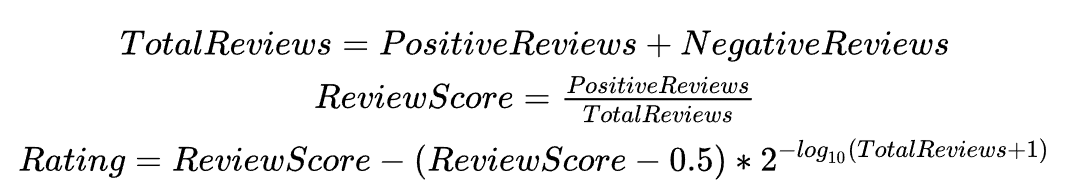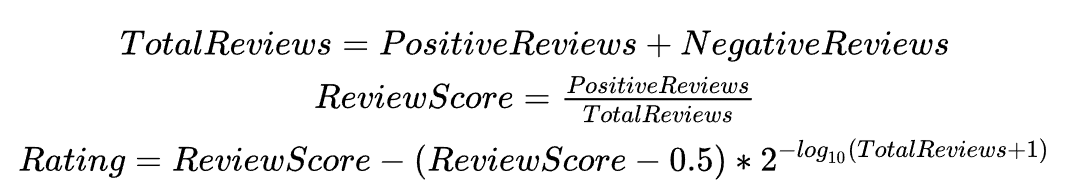

In [164]:
reviews["rating"] = (
                        reviews["total_positive"]/reviews["total_reviews"] - 
                        (reviews["total_positive"]/reviews["total_reviews"] - 0.5)*np.power(2,-np.log10(reviews["total_reviews"]+1))
                    )*100

Let's check the games with the highest reviews:

In [165]:
temp_df = pd.concat([storefront,reviews], ignore_index=False, axis = 1)
temp_df.sort_values(by='rating', ascending = False)[['name','review_score','total_positive','total_negative','rating']]

,name,review_score,total_positive,total_negative,rating
appid,,,,,
620,Portal 2,9.0,234828.0,2820.0,97.637876
1118200,People Playground,9.0,108309.0,1119.0,97.487823
1794680,Vampire Survivors,9.0,93523.0,968.0,97.418751
427520,Factorio,9.0,106872.0,1187.0,97.408600
1145360,Hades,9.0,171135.0,2345.0,97.360320
...,...,...,...,...,...
2009270,Othello: Daynight Time Clash - 18+ Expansion Pack,0.0,0.0,0.0,NaN
2028023,Total War Saga: FALL OF THE SAMURAI – Blood Pack,0.0,0.0,0.0,NaN
2028055,Tom Clancy's Ghost Recon Future Soldier - Seas...,0.0,0.0,0.0,NaN


This correlates with what we see at https://steamdb.info/stats/gameratings/ . As you can see, the numbers of reviews are somewhat different, the reason being that we've downloaded only reviews for people that bought the game from Steam.

In [166]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102521 entries, 10 to 2028850
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       102521 non-null  float64
 1   review_score_desc  102521 non-null  object 
 2   total_positive     102521 non-null  float64
 3   total_negative     102521 non-null  float64
 4   total_reviews      102521 non-null  float64
 5   metacritic_score   3825 non-null    float64
 6   metacritic_url     3825 non-null    object 
 7   rating             64786 non-null   float64
dtypes: float64(6), object(2)
memory usage: 11.1+ MB


In the mathematical operations we got a lot of NaNs, due to games with 0 total reviews. Let's assign them a score of 50%, as the medium point. This is the same approach used in the algorithm above.

In [167]:
reviews["rating"] = reviews["rating"].fillna(50.0)

Let's also remove the excessive entries from reviews if they are present:

In [168]:
def df_remove_excesses(df_primary, df_secondary):
    excesses = df_secondary.index.difference(df_primary.index)
    df_secondary = df_secondary.drop(excesses, axis=0)
    return df_secondary

And remove the field that contain the excessive information:
* total_reviews - we can calculate them by using total_positive and total_negative
* review_score_desc - we can describe the scores in the review_score metadata if needed.

In [169]:
reviews = df_remove_excesses(storefront,reviews)
reviews.drop([
        'total_reviews', 'review_score_desc'
    ], axis=1, inplace = True)

We'll decide how we are going to  join/split the table close to the end and leave the reviews for now.

# SteamSpy

This table contains data collected from SteamSpy. The columns are:

| Column  | Description |
| --- | --- |
| appid | Appid, used as index |
| name | Application name |
| developers | Application developers |
| publishers | Application publishers |
| score_rank| Steam reviews score rank |
| total_positive | Positive reviews count|
| total_negative | Negative reviews count |
| review_score | Steam review score |
| owners | Estimated owner numbers |
| average_forever | Average playtime |
| average_2weeks | Average playtime in the last two weeks |
| median_forever | Median playtime |
| median_2weeks | Median playtime in the last two weeks |
| price | Current game price |
| initialprice | Initial game price |
| discount | Discount |
| supported_languages | Supported languages |
| genres | App Genres |
| ccu | Peak concurrent players on the day before the data collection (*not the max historical!*) |
| tags | User tags with counts |


We have already got the clean data for most of the fields from the Storefront and Reviews tables. Also, the data from SteamSpy is not as complete and recent comparing to the one directy downloaded from Steam. These columns are:
- appid
- name
- developers
- publishers
- score_rank
- total_positive
- total_negative
- review_score
- price
- initialprice
- discount
- supported_languages
- genres
 
I'll still take a quick look on this fields one by one.

The columns we are interested in:
- owners
- average_forever
- average_2weeks
- median_forever
- median_2weeks
- ccu
- tags

### Conforming the table rows to the same ids as in the main storefront table:


In [170]:
steamspy = df_remove_excesses(storefront,steamspy)


I'll create a temporary table merging storefront, reviews and steamspy for the steamspy data check

In [171]:
storefront_s = pd.concat([storefront, reviews.add_suffix("_reviews"), steamspy.add_suffix("_steamspy")], axis = 1)

## Columns we already have good data data on
### name
Application name. We've already worked with it on the storefront so it's of no use to us.

In [172]:
print('name nulls count:', steamspy['name'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[["name", "name_steamspy"]].sample(5))

name nulls count: 222


,name,name_steamspy
appid,,
1474280,Last Kingdom - The Card Game,Last Kingdom - The Card Game
1692759,Tiger Tank 59 Ⅰ Rainstorm MP010,Tiger Tank 59 Ⅰ Rainstorm MP010
789160,Plastic Rebellion,Plastic Rebellion
1242820,GirLand,GirLand
343951,FSX: Steam Edition - Discover Great Britain Add-On,FSX: Steam Edition - Discover Great Britain Add-On


### developers
Developers. We've already worked with it on the storefront so it's of no use to us.

In [173]:
print('developers nulls count:', storefront_s['developers_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[["name", "developers", "developers_steamspy"]].sample(5))

developers nulls count: 10192


,name,developers,developers_steamspy
appid,,,
1581590,VR Nara Park,"['x-climb, Inc.']","x-climb, Inc."
878470,70 Seconds Survival,"['Tero Lunkka', 'Valkeala Software']","Tero Lunkka, Valkeala Software"
1011940,Ideology in Friction,['ONEONE1'],ONEONE1
1769470,Non-Euclidean Chess,"['Cole Ferguson', 'Will Bowers']","Cole Ferguson, Will Bowers"
1897330,Helga the Viking Warrior,['eFunSoft Games'],eFunSoft Games


### publishers
Publishers. We've already worked with it on the storefront so it's of no use to us.

In [174]:
print('publishers nulls count:', storefront_s['publishers_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[["name", "publishers", "publishers_steamspy"]].sample(5))

publishers nulls count: 19355


,name,publishers,publishers_steamspy
appid,,,
1111970,Zeminator,['Richard Haraším'],Richard Haraším
1155800,Voyagers,['Enki'],Enki
1279370,TENGAI,['CITY CONNECTION'],CITY CONNECTION
815352,Call of War: 49.500 Gold,['Bytro Labs GmbH'],NaN
603550,Schlag den Star - Das Spiel,['bitComposer Interactive GmbH'],bitComposer Interactive GmbH


### score_rank
Steam review score rank. We've already worked with it on the storefront so it's of no use to us.

In [175]:
print('score_rank nulls count:', storefront_s['score_rank_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["score_rank_steamspy"].notnull()][["name", "rating_reviews", "score_rank_steamspy"]].sample(5))

score_rank nulls count: 102458


,name,rating_reviews,score_rank_steamspy
appid,,,
944540,House Party - Explicit Content Add-On,54.326015,100.0
914140,Hentai Dojo,59.005246,98.0
946800,Hentai 2+2=4,53.966961,98.0
962380,HOT FIT!,59.599704,99.0
639780,Deep Space Waifu: FLAT JUSTICE,89.844427,100.0


### total_positive
Total number of positive reviews. We've already worked with it on the storefront so it's of no use to us.

In [176]:
print('total_positive nulls count:', storefront_s['total_positive_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["total_positive_steamspy"]>0][["name", "total_positive_reviews", "total_positive_steamspy"]].sample(5))

total_positive nulls count: 0


,name,total_positive_reviews,total_positive_steamspy
appid,,,
1398080,Seaside Cafe Story,5.0,11
886350,Clouded,4.0,6
368760,Playing History: Vikings,6.0,18
1547420,Siphonophore,1.0,3
1088090,Day of Dragons,1818.0,2393


### total_negative
Total number of negative reviews. We've already worked with it on the storefront so it's of no use to us.

In [177]:
print('total_negative nulls count:', storefront_s['total_negative_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["total_negative_steamspy"]>0][["name", "total_negative_reviews", "total_negative_steamspy"]].sample(5))

total_negative nulls count: 0


,name,total_negative_reviews,total_negative_steamspy
appid,,,
1885540,SEARCH ALL - CATS,2.0,2
612900,PAYDAY 2: Gage Russian Weapon Pack,110.0,106
524320,Krimson Ermac,12.0,6
816550,Gallows,3.0,3
1543100,Farmers Co-op: Out of This World,1.0,1


### review_score
Review score. We've already worked with it on the storefront so it's of no use to us.

In [178]:
print('review_score nulls count:', storefront_s['review_score_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["review_score_steamspy"]>0][["name", "review_score_reviews", "review_score_steamspy"]].sample(5))

review_score nulls count: 0


,name,review_score_reviews,review_score_steamspy
appid,,,
962380,HOT FIT!,0.0,80
603120,Happy Campers,5.0,46
975020,The Spirit Master of Retarnia -Conqueror of the Labyrinth-,5.0,71
958480,Seed of the Dead,6.0,84
929310,Kamasutra Connect : Sexy Hentai Girls,5.0,68


### price
Current price (including discounts). We've already worked with it on the storefront so it's of no use to us.

In [179]:
print('price nulls count:', storefront_s['price_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["price_steamspy"]>0][["name", "price", "price_steamspy"]].sample(5))

price nulls count: 9881


,name,price,price_steamspy
appid,,,
671170,Great eSports Manager,9.99,999.0
672030,Swap Blocks,4.99,499.0
1115140,World of Guns VR: Guns Full Access,41.99,4999.0
1120240,Ded Inside,2.39,299.0
1794400,Plinko Panic!,5.69,699.0


### initialprice
Price without the discount. We've already worked with it on the storefront so it's of no use to us.

In [180]:
print('price nulls count:', storefront_s['initialprice_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["initialprice_steamspy"]>0][["name", "price", "initialprice_steamspy"]].sample(5))

price nulls count: 9879


,name,price,initialprice_steamspy
appid,,,
616490,Post War Dreams,7.39,899.0
632170,Spartan Fist,12.49,1499.0
905880,Caves of Plague,1.59,199.0
607100,Kith - Lorebook,0.99,99.0
1541890,Private Agent,3.99,499.0


### discount
Current dicount. We've already worked with it on the storefront so it's of no use to us.

In [181]:
print('discount nulls count:', storefront_s['discount_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["discount_steamspy"]>0][["name", "price_steamspy", "initialprice_steamspy", "discount_steamspy"]].sample(5))

discount nulls count: 9879


,name,price_steamspy,initialprice_steamspy,discount_steamspy
appid,,,,
900580,RIDE 3 - Back to Basic Pack,74.0,499.0,85.0
1246186,Super Jigsaw Puzzle: Generations - Random Animals Puzzles,269.0,899.0,70.0
1345280,Slide - Animal Race,974.0,1299.0,25.0
393831,Magicka 2: Three Cardinals Robe Pack,249.0,499.0,50.0
1799500,Stopocop,499.0,999.0,50.0


### supported_languages
Supported languages. Here languages are not divided on autio/text. We've already worked with this data on the storefront so it's of no use to us.

In [182]:
print('supported_languages nulls count:', storefront_s['supported_languages_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["supported_languages_steamspy"].notnull()][[
        "name",
        "supported_audio",
        "supported_languages",
        "supported_languages_steamspy"
    ]].sample(5))

supported_languages nulls count: 10047


,name,supported_audio,supported_languages,supported_languages_steamspy
appid,,,,
628180,Winning Post,NaN,[Japanese],Japanese
1164310,Fairytale Solitaire. Witch Charms,NaN,"[English, French, German, Russian]","English, French, German, Russian"
849311,Shadow of the Tomb Raider - The Grand Caiman,"[ Arabic, Polish, English, French, German, Italian, Portuguese - Brazil, Russian, Simplified Chinese, Spanish - Spain]","[Arabic, English, French, German, Italian, Korean, Polish, Portuguese - Brazil, Russian, Simplified Chinese, Spanish - Spain, Traditional Chinese]","English, French, Italian, German, Spanish - Spain, Korean, Polish, Portuguese - Brazil, Russian, Simplified Chinese, Traditional Chinese, Arabic"
405610,Flight of the Paladin,[English],[English],English
1403280,Struggle Offensive,NaN,[English],English


### genres
Genres. We've already worked with this data on the storefront so it's of no use to us.

In [183]:
print('genres nulls count:', storefront_s['genres_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["genres_steamspy"].notnull()][["name", "genres", "genres_steamspy"]].sample(5))

genres nulls count: 10130


,name,genres,genres_steamspy
appid,,,
1676560,Redux,"[Indie, Strategy]","Indie, Strategy"
1084710,Climbros,"[Action, Adventure, Casual, Indie, Simulation]","Action, Adventure, Casual, Indie, Simulation"
1517211,Zombie Army 4: Afrika Karl Outfit,[Action],Action
1419820,King of Volleyball Adults Only 18+ Patch,"[Casual, Indie]","Casual, Indie"
1650670,Sokobear: Winter,"[Casual, Indie]","Casual, Indie"


## Columns requiring analysis

### Owners
SteamSpy owners estimation. A string with lower .. upper application owners estimates. We could split it into two for lower and upper estimations but I'll just slightly reformat it to keep consistent with Nik Davis dataset.

In [184]:
print('owners nulls count:', storefront_s['owners_steamspy'].isnull().sum())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["owners_steamspy"].notnull()][["name", "owners_steamspy"]].sample(5))

owners nulls count: 0


,name,owners_steamspy
appid,,
1680167,Tiger Tank 59 Ⅰ Battleship MP078,"0 .. 20,000"
1325900,Demon Turf,"0 .. 20,000"
659920,Transports,"0 .. 20,000"
871241,RPG Maker VX Ace - Karugamo Fantasy BGM Pack 06,"0 .. 20,000"
1974410,Star Hearts: Launch Point,"0 .. 20,000"


#### [Subroutine] 'owners': Cleaning

In [185]:
def owners_clean(df):
    """
    Reformatting owners column to lower-upper format
    """
    df = df.copy()
    df['owners'] = df['owners'].str.replace(',', '', regex=True).str.replace(' .. ', '-', regex=True)
    return df

In [186]:
steamspy = owners_clean(steamspy)

In [187]:
steamspy.sample(10)

,name,developers,publishers,score_rank,total_positive,total_negative,review_score,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,supported_languages,genres,ccu,tags
appid,,,,,,,,,,,,,,,,,,,
2000480,The Meaning,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
1654170,Agony VR,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
749820,Villages,HAILFALLKOMPANY,HAILFALLKOMPANY,NaN,0,0,0,0-20000,0,0,0,0,0.0,0.0,0.0,English,"Action, Indie, RPG, Simulation",0,[]
1926070,The Forgotten Demons,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
585750,Chowdertwo,Ryan Jensen,Ryan Jensen,NaN,7,2,0,20000-50000,280,0,318,0,299.0,299.0,0.0,English,"Action, Adventure, Indie",0,"{'Adventure': 31, 'Indie': 23, 'Action': 22, '..."
1425640,Minestrife,Tilenauts,Tilenauts,NaN,3,0,0,0-20000,0,0,0,0,399.0,399.0,0.0,English,Strategy,0,"{'Strategy': 57, 'Puzzle': 47, 'Board Game': 3..."
881670,Screensavers VR,FLOAT LAND,FLOAT LAND,NaN,4,2,0,0-20000,0,0,0,0,999.0,999.0,0.0,English,"Casual, Indie, Simulation",0,"{'Casual': 61, 'Simulation': 61, 'Indie': 61, ..."
417461,Tom Clancy's Rainbow Six Siege - The Safari Bu...,Ubisoft Montreal,NaN,NaN,631,89,0,0-20000,0,0,0,0,499.0,499.0,0.0,"English, French, Italian, German, Spanish - Sp...",Action,0,{'Action': 28}
818880,Fantasy Grounds - Mythic Monsters #31: Daemons...,"SmiteWorks USA, LLC",NaN,NaN,0,0,0,0-20000,0,0,0,0,799.0,799.0,0.0,English,"Indie, RPG, Strategy",0,[]


### average_forever 

Average player playtime. We have some nulls (since we don't have data for some games). We will replace it with 0 to keep consistent with data on SteamSpy.

In [188]:
print('average_forever nulls count:', storefront_s['average_forever_steamspy'].isnull().sum())
print('average_forever zero count:', storefront_s[storefront_s["average_forever_steamspy"]==0]['average_forever_steamspy'].count())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["average_forever_steamspy"].notnull()][["name", "average_forever_steamspy"]].sample(5))

average_forever nulls count: 0
average_forever zero count: 90443


,name,average_forever_steamspy
appid,,
761890,Albion Online,3607
827690,Armored Warfare - Merkava IID Black Eagle,0
1862410,Fantasy Grounds - D&D Classics: R1 To the Aid of Falx,0
432500,Evertown,0
1668180,M.A.R.S. Starter Pack,0


#### [Subroutine] 'average_forever': Cleaning

In [189]:
def average_forever_clean(df):
    """
    Cleaning average_forever in SteamSpy
    """
    df = df.copy()
    df['average_forever'].fillna(0)
    return df

In [190]:
steamspy = average_forever_clean(steamspy)

### average_2weeks 

Average player playtime in the last 2 weeks. While the data is interesting, it's only the last two weeks so it doesn't seem valuable in the long term. Going to drop.

In [191]:
print('average_2weeks nulls count:', storefront_s['average_2weeks_steamspy'].isnull().sum())
print('average_2weeks zero count:', storefront_s[storefront_s["average_2weeks_steamspy"]==0]["average_2weeks_steamspy"].count())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["average_2weeks_steamspy"].notnull()][["name", "average_2weeks_steamspy"]].sample(5))

average_2weeks nulls count: 0
average_2weeks zero count: 101067


,name,average_2weeks_steamspy
appid,,
1222790,Crossing Frontier 盡界戰線,0
1347010,Dim Glow,0
1692750,Tiger Tank 59 Ⅰ Rainstorm MP001,0
1700517,Tiger Fighter 1931 MP048,0
660900,Dark Mystery,0


### median_forever 

Median player playtime. We have some nulls (since we don't have data for some games). We will replace it with 0 to keep consistent with data on SteamSpy.

In [192]:
print('median_forever nulls count:', storefront_s['median_forever_steamspy'].isnull().sum())
print('median_forever zero count:', storefront_s[storefront_s["median_forever_steamspy"]==0]["median_forever_steamspy"].count())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["median_forever_steamspy"].notnull()][["name", "median_forever_steamspy"]].sample(5))

median_forever nulls count: 0
median_forever zero count: 90443


,name,median_forever_steamspy
appid,,
954010,Definitely Sneaky But Not Sneaky,0
675340,X-Plane 11 - Add-on: Aerosoft - Airport Bali,0
940590,Double Pug Switch,0
1210910,Night Of The Living Dead VR,0
1381570,Trainz 2019 DLC - RZD-UZ-RIC Wagons Praha,0


#### [Subroutine] 'median_forever': Cleaning

In [193]:
def median_forever_clean(df):
    """
    Cleaning average_forever in SteamSpy
    """
    df = df.copy()
    df['median_forever'].fillna(0)
    return df

In [194]:
steamspy = median_forever_clean(steamspy)

### median_2weeks 

Median player playtime in the last 2 weeks. While the data is interesting, it's only the last two weeks so it doesn't seem valuable in the long term. Going to drop.

In [195]:
print('median_2weeks nulls count:', storefront_s['median_2weeks_steamspy'].isnull().sum())
print('median_2weeks zero count:', storefront_s[storefront_s["median_2weeks_steamspy"]==0]["median_2weeks_steamspy"].count())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["median_2weeks_steamspy"].notnull()][["name", "median_2weeks_steamspy"]].sample(5))

median_2weeks nulls count: 0
median_2weeks zero count: 101067


,name,median_2weeks_steamspy
appid,,
512622,Reigns - Songs of Reigns: Interactive OST,0
1357680,Dungeon Dan,0
1969830,Dadish 3,0
1089218,Rocksmith® 2014 Edition – Remastered – Women Who Rock Song Pack II,0
290970,1849,0


### ccu 

Peak concurrent user count. This is a very interesting stat. Sadly, it's not a lifetime stat, but the stat for the day before the dataset is downloaded so it's not useful for analysis. Going to drop.

In [196]:
print('ccu nulls count:', storefront_s['ccu_steamspy'].isnull().sum())
print('ccu zero count:', storefront_s[storefront_s["ccu_steamspy"]==0]["ccu_steamspy"].count())
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["ccu_steamspy"].notnull()][["name", "ccu_steamspy"]].sample(5))

ccu nulls count: 0
ccu zero count: 86585


,name,ccu_steamspy
appid,,
1792200,Underworld Dreams: The False King,0
1820343,Zombie Army 4: Josiah Detective Outfit,0
509745,Rocksmith® 2014 Edition – Remastered – Skid Row - “I Remember You”,0
698980,sWORD MASTER,0
1026660,ItazuraVR - Sweatshirts,0


### tags

User tags data. It includes both the tag and the number of users that put the tag. A dict with 'tag_name':tag_count elements.

I'll save just the tags themselves in the main table and move tags with tag numbers to the separate one.

In [197]:
print('tags nulls count:', storefront_s['tags_steamspy'].isnull().sum())
print('tags empty list count:', storefront_s[~storefront_s['tags_steamspy'].apply(lambda x: False if pd.isna(x) else bool(ast.literal_eval(x)))].shape[0])
with pd.option_context("display.max_colwidth", 150):
    display(storefront_s[storefront_s["tags_steamspy"].notnull()][["name", "tags_steamspy"]].sample(5))

tags nulls count: 0
tags empty list count: 41456


,name,tags_steamspy
appid,,
942200,Rocket Boots Mania,"{'Early Access': 172, 'Open World': 156, 'Action': 150, 'Parkour': 147, '3D Platformer': 144, 'Platformer': 139, 'Exploration': 132, 'Adventure': ..."
628570,Trivia Night,"{'Indie': 45, 'Casual': 43, 'Early Access': 29, 'Local Multiplayer': 23, 'Choices Matter': 14, '4 Player Local': 13, 'Family Friendly': 13, '2D': ..."
904780,DeepWeb,"{'Action': 31, 'Indie': 31, 'First-Person': 12, 'Puzzle': 11, 'Great Soundtrack': 11, 'Singleplayer': 11, '3D Platformer': 11, 'Difficult': 10, 'B..."
1782330,Green Hell VR,[]
491496,FSX Steam Edition: North American F-86F-1 Sabre™ Add-On,{'Simulation': 21}


#### [Subroutine] 'tags': Cleaning

In [198]:
def clean_tags(df, export=False):
    """
    Processing SteamSpy tags with possible export.
    For exporting, we are spreading the tags to columns and put the number of users using the said tag as a value
    tags are renamed to comply with pandas column names requirements    
    
    We are leaving only the tags themselves in the table
    """    
    if export: 
        
        tag_data = df[['tags']].copy()
        
        def parse_export_tags(x):
            if pd.isnull(x):
                return {}
            x = ast.literal_eval(x)

            if isinstance(x, dict):
                return x
            elif isinstance(x, list):
                return {}
            else:
                raise TypeError('Something other than dict or list found')

        tag_data['tags'] = tag_data['tags'].apply(parse_export_tags)

        # Getting all tags for column names
        cols = set(itertools.chain(*tag_data['tags']))

        # And setting the user values
        for col in sorted(cols):
            col_name = col.lower().replace(' ', '_').replace('-', '_').replace("'", "")

            tag_data[col_name] = tag_data['tags'].apply(lambda x: x[col] if col in x.keys() else 0)

        tag_data = tag_data.drop('tags', axis=1)
        
        export_data(tag_data, 'steamspy_tag_data', index=True)
        print("Exported tag data")
        
        
    def parse_tags(x):
        if pd.isnull(x):
            return np.nan
        x = ast.literal_eval(x)
        
        if isinstance(x, dict):
            return list(x.keys())
        else:
            return np.nan
    
    df['tags'] = df['tags'].apply(parse_tags)
       
    return df

In [199]:
steamspy = clean_tags(steamspy, export = True)

C:\Users\ilkar399\AppData\Local\Temp/ipykernel_30116/4285575321.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_data[col_name] = tag_data['tags'].apply(lambda x: x[col] if col in x.keys() else 0)


Exported steamspy_tag_data to '../data/export/steamspy_tag_data.csv'
Exported tag data


In [200]:
#Verifying exported data
pd.read_csv('../data/export/steamspy_tag_data.csv').sample(10)

,appid,1980s,1990s,2.5d,2d,2d_fighter,2d_platformer,360_video,3d,3d_fighter,...,web_publishing,well_written,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
78015,1546200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3590,249111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12049,404590,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22488,592292,0,0,0,0,0,0,0,0,0,...,21,0,0,0,0,0,0,0,0,0
73550,1464540,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31350,753748,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8861,351680,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30998,747790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28100,694660,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
56494,1174180,0,0,0,0,0,0,0,0,0,...,0,0,0,1387,0,0,0,0,0,0


### [Subroutine] SteamSpy: dropping columns

In [201]:
steamspy = steamspy.drop([
        'name', 'developers', 'publishers', 'score_rank', 'total_positive', 'total_negative', 'review_score',
    'price', 'initialprice', 'discount', 'supported_languages', 'genres', 'average_2weeks', 'median_2weeks',
    'ccu'
    ], axis=1)

After the processing, our SteamSpy data table will look like this:

In [202]:
steamspy.sample(10)

,owners,average_forever,median_forever,tags
appid,,,,
415570,0-20000,0,0,"[Strategy, RPG, Indie, Online Co-Op, Utilities..."
1332380,0-20000,0,0,"[Casual, Runner, Clicker, Difficult, RPG, Arca..."
823430,0-20000,0,0,NaN
1350120,0-20000,0,0,"[RPG, Souls-like, Philosophical, Relaxing, Mys..."
891230,0-20000,0,0,"[Simulation, Strategy]"
1524250,0-20000,0,0,"[Multiple Endings, Choose Your Own Adventure, ..."
380920,0-20000,0,0,"[Action, Adventure, Indie, Shoot 'Em Up, 2D, A..."
1365180,0-20000,0,0,NaN
348290,20000-50000,0,0,"[Management, Simulation, Medical Sim, Casual]"


We'll combine it with storefront and review data into one Steam data table:

In [203]:
steam = pd.concat([storefront,reviews,steamspy], ignore_index=False, axis = 1)

In [204]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102504 entries, 10 to 2028850
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   type                     102504 non-null  object        
 1   name                     102504 non-null  object        
 2   required_age             102504 non-null  int64         
 3   dlc                      9696 non-null    object        
 4   fullgame                 34607 non-null   object        
 5   supported_languages      102352 non-null  object        
 6   drm_notice               706 non-null     object        
 7   ext_user_account_notice  1037 non-null    object        
 8   developers               102463 non-null  object        
 9   publishers               102464 non-null  object        
 10  demos                    6504 non-null    object        
 11  packages                 81153 non-null   object        
 12  platforms     

In [205]:
steam.sample(10)

,type,name,required_age,dlc,fullgame,supported_languages,drm_notice,ext_user_account_notice,developers,publishers,...,review_score,total_positive,total_negative,metacritic_score,metacritic_url,rating,owners,average_forever,median_forever,tags
appid,,,,,,,,,,,,,,,,,,,,,
1969000,game,Yupitergrad 2: The Lost Station,0,NaN,NaN,"[Arabic, English, French, German, Japanese, Ko...",NaN,NaN,['Gamedust'],['Gamedust'],...,0.0,0.0,0.0,NaN,NaN,50.000000,0-20000,0,0,NaN
357670,game,Home Improvisation: Furniture Sandbox,0,NaN,NaN,[English],NaN,NaN,['The Stork Burnt Down'],['The Stork Burnt Down'],...,5.0,136.0,60.0,NaN,NaN,65.435687,20000-50000,149,150,"[Simulation, Indie, Casual, Local Co-Op, VR, O..."
390120,dlc,ADventure Lib Original Soundtrack,0,NaN,"{'appid': '374950', 'name': 'ADventure Lib'}",[English],NaN,NaN,['Fancy Fish Games'],['Fancy Fish Games'],...,0.0,0.0,0.0,NaN,NaN,50.000000,0-20000,0,0,NaN
1696030,game,Evelyn's Adventure,0,NaN,NaN,"[English, Japanese, Spanish - Spain]",NaN,NaN,"['Capturedleek27', 'Doky']",['Capky Games'],...,0.0,0.0,0.0,NaN,NaN,50.000000,0-20000,0,0,NaN
1383850,game,Gurobu,0,NaN,NaN,"[English, Portuguese, Portuguese - Brazil, Rus...",NaN,NaN,['Aiaz Marx'],['Aiaz Marx'],...,7.0,17.0,0.0,NaN,NaN,79.054278,20000-50000,0,0,"[2D, RPGMaker, Pixel Graphics, Anime, Choices ..."
1818320,game,いせかいあどべんちゃー,0,NaN,NaN,[Japanese],NaN,NaN,['OyFyBy'],['OyFyBy'],...,5.0,15.0,7.0,NaN,NaN,61.106982,20000-50000,0,0,"[Exploration, 2D Platformer, Rogue-lite, Party..."
1419840,dlc,Tabletopia - Constellations,0,NaN,"{'appid': '402560', 'name': 'Tabletopia'}",[English],NaN,NaN,"['Ian Zang', 'Dante Lauretta', 'Ashley Kenawell']",['Tabletopia'],...,0.0,0.0,0.0,NaN,NaN,50.000000,0-20000,0,0,NaN
842130,game,Sunny Smiles,0,NaN,NaN,[English],NaN,NaN,['indie_games_studio'],['indie_games_studio'],...,0.0,3.0,0.0,NaN,NaN,67.059371,0-20000,0,0,"[Adventure, Indie, Simulation, Platformer, Bea..."
1484010,game,Farty Bird,0,NaN,NaN,[English],NaN,NaN,['Bro Code'],['Bro Code'],...,0.0,1.0,0.0,NaN,NaN,59.416365,0-20000,0,0,"[2D, Pixel Graphics, Procedural Generation, Co..."


# Finalizing table structure

After the processing have these tables available:

* steam
* steam_description_data
* steam_media_data
* steam_packages_info
* steam_requirements_data
* steam_support_info
* steamspy_tag_data
* missing_ids

Sadly, there are a lot of optional data in the steam table so it might be a good idea to move it to the optional table and join with the main table when necessary. The fields that go to the **steam_optional** are:

* drm_notice
* ext_user_account_notice
* demos
* content_descriptors
* metacritic_score
* metacritic_url

### [Subroutine] steam and steam_optional export

In [206]:
def steam_export(df):
    """
    Creating steam_optional table and exporting both steam and steam_optional
    """
    df = df.copy()
    # copying necessary columns into new df
    steam_optional_df = df[[
        "drm_notice",
        "ext_user_account_notice",
        "demos",
        "content_descriptors",
        "metacritic_score",
        "metacritic_url",
    ]].copy()
    
    # removing empty rows
    steam_optional_df.dropna(how = 'all', inplace=True)
           
    # dropping unnneeded columns from the main dataframe
    df = df.drop([
        "drm_notice",
        "ext_user_account_notice",
        "demos",
        "content_descriptors",
        "metacritic_score",
        "metacritic_url",
    ], axis=1)
    
    export_data(df, 'steam', index=True)
    export_data(steam_optional_df, 'steam_optional', index=True)

In [207]:
steam_export(steam)

Exported steam to '../data/export/steam.csv'
Exported steam_optional to '../data/export/steam_optional.csv'


In [208]:
# Verifying exported steam data
pd.read_csv('../data/export/steam.csv').sample(5)

,appid,type,name,required_age,dlc,fullgame,supported_languages,developers,publishers,packages,...,coming_soon,price,review_score,total_positive,total_negative,rating,owners,average_forever,median_forever,tags
14064,439470,dlc,Shadow Puppeteer Soundtrack,0,NaN,"{'appid': '316480', 'name': 'Shadow Puppeteer'}","['Danish', 'English', 'French', 'German', 'Ita...",['Sarepta studio'],['Snow Cannon Games'],[92724],...,False,2.99,0.0,0.0,0.0,50.000000,0-20000,0,0,NaN
76053,1508660,game,正宗台灣十六張麻將2,0,NaN,NaN,['Traditional Chinese'],['SOFTSTAR ENTERTAINMENT'],['SOFTSTAR ENTERTAINMENT'],[531897],...,False,2.39,7.0,20.0,3.0,72.759210,0-20000,0,0,"['Casual', 'Card Game', 'Tabletop', '2D', 'Fun..."
56110,1168330,dlc,Utawarerumono - Tamaki Swimsuit Ver.,0,NaN,"{'appid': '1149550', 'name': 'Utawarerumono: M...","['English', 'Japanese', 'Traditional Chinese']",['AQUAPLUS'],"['DMM GAMES', 'Shiravune']",[399231],...,False,2.39,0.0,1.0,1.0,50.000000,0-20000,0,0,NaN
96981,1864210,game,Zombie War,0,NaN,NaN,"['English', 'Korean']",['YongHo Joo'],['YongHo Joo'],[670682],...,False,5.69,0.0,2.0,0.0,64.079515,0-20000,0,0,"['Action', 'FPS', 'Shooter', '3D', 'Zombies', ..."
2410,214730,game,Space Rangers HD: A War Apart,0,NaN,NaN,"['English', 'Russian']","['SNK Games', 'Elemental Games', 'Katauri Inte...",['1C Entertainment'],[26388],...,False,14.99,8.0,4002.0,238.0,90.795283,200000-500000,3932,5269,"['Space', 'RPG', 'Strategy', 'Adventure', 'Sim..."


In [209]:
# Verifying exported steam_optional data
pd.read_csv('../data/export/steam_optional.csv').sample(5)

,appid,drm_notice,ext_user_account_notice,demos,content_descriptors,metacritic_score,metacritic_url
16461,1528000,NaN,NaN,NaN,This Game may contain content not appropriate ...,NaN,NaN
13414,1324560,NaN,Independent developer,NaN,Cartoon hack'n slash violence.,NaN,NaN
14957,1426190,NaN,NaN,NaN,Content in this product may not be appropriate...,NaN,NaN
11570,1222170,NaN,NaN,[1223330],NaN,NaN,NaN
5865,861050,NaN,www.DemonsAreCrazy.com,NaN,NaN,NaN,NaN


### [Subroutine] missing_ids export

In [210]:
export_data(missing_ids, 'missing_ids', index=True)

Exported missing_ids to '../data/export/missing_ids.csv'


# Combined clean-up script

# TODO

In [211]:
def combined_cleanup():
    
    
    return True

# Tests

In [212]:
# Testing if the number of rows is consistent between the pre and post processing
def row_check():
    pre_count = pd.read_csv("../data/processing/steam_app_data.csv").shape[0]
    print("Number of rows before processing:", pre_count)
    missing_count_pre = pd.read_csv('../data/processing/missing_ids.csv').shape[0]
    print("Number of missing before processing:", missing_count_pre)
    post_count = pd.read_csv('../data/export/steam.csv').shape[0]
    print("Number of rows after processing:", post_count)
    missing_count_post = pd.read_csv('../data/export/missing_ids.csv').shape[0]
    print("Number of missing after processing:", missing_count_post)
    if ((pre_count + missing_count_pre) == (post_count + missing_count_post)):
        return True
    return False

In [213]:
print("Number of rows test results:", row_check())

C:\Users\ilkar399\AppData\Local\Temp/ipykernel_30116/2930490769.py:1: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  print("Number of rows test results:", row_check())


Number of rows before processing: 103185
Number of missing before processing: 20
Number of rows after processing: 102504
Number of missing after processing: 701
Number of rows test results: True
